In [1]:
import os, subprocess
import time
import numpy as np
from pprint import pprint

from simtk import unit
from simtk.openmm import app, LangevinIntegrator
from simtk.openmm.app import PDBFile

import parmed as pmd
from parmed.utils.six import string_types

import matplotlib.pyplot as plt
import mpld3

# Choose underlying toolkits
Choose the toolkit(s) you want to use with the OpenFF toolkit (either OpenEye or Ambertools and RDKit)

In [2]:
from openforcefield.utils import toolkits

### OpenEye version: uncomment the following if you have and if you want to use the OpenEye toolkit, then RDKit and Ambertools toolkits
# toolkit_precedence = [toolkits.OpenEyeToolkitWrapper, toolkits.RDKitToolkitWrapper, toolkits.AmberToolsToolkitWrapper]

### Non-OpenEye version: uncomment the following if you want to use the rdkit and ambertools
toolkit_precedence = [toolkits.RDKitToolkitWrapper, toolkits.AmberToolsToolkitWrapper]

toolkits.GLOBAL_TOOLKIT_REGISTRY = toolkits.ToolkitRegistry(toolkit_precedence=toolkit_precedence)

Unable to load toolkit <openforcefield.utils.toolkits.OpenEyeToolkitWrapper object at 0x7fe69b019ba8>.


In [3]:
from openforcefield.topology import Molecule, Topology
from openforcefield.typing.engines.smirnoff import ForceField
from openforcefield.tests.utils import compare_system_parameters, compare_system_energies

In [4]:
# choose the force field:
# not yet the release version!
openff_forcefield = ForceField('smirnoff99Frosst-1.1.0.offxml')

In [5]:
# function to convert openFF molecule (ligand) to a parmed structure
def ligandToPMD(ligand):
    ligand_positions = ligand.conformers[0]
    
    # Calculate am1bcc charges and fix them such that they add up to zero (4 digit precision)
    try:
        ligand.compute_partial_charges_am1bcc()
    except Exception as e:
        raise Exception('Error in charge calculation for ligand {}: {}'.format(ligand.name, e))
    # Give all atoms unique names so we can export to GROMACS
    for idx, atom in enumerate(ligand.atoms):
        atom.name = f'{atom.element.symbol}{idx}'
    
    # Do not assign H-bond constraints now, instead have ParmEd add them later
    del openff_forcefield._parameter_handlers['Constraints']

    ligand_topology = ligand.to_topology()
    try:
        ligand_system = openff_forcefield.create_openmm_system(ligand_topology, charge_from_molecules=[ligand])
    except Exception as e:
        raise Exception('Error in creating openmm system: {}'.format(e))
    # Create OpenMM Topology from OpenFF Topology
    omm_top = ligand_topology.to_openmm()


    # Convert OpenMM System to a ParmEd structure.
    pmd_structure = pmd.openmm.load_topology(omm_top, ligand_system, ligand_positions)

    return pmd_structure, ligand_topology, ligand_system, ligand_positions

In [6]:
# function for analyzing energy contributions of openMM energies
def forcegroupify(system):
    forcegroups = {}
    for i in range(system.getNumForces()):
        force = system.getForce(i)
        force.setForceGroup(i)
        forcegroups[(type(force)).__name__] = i
    return forcegroups

def getEnergyDecomposition(context, forcegroups):
    energies = {}
    for f, i in forcegroups.items():
        energies[f] = context.getState(getEnergy=True, groups=2**i).getPotentialEnergy()
    energies['TotalPotential'] = context.getState(getEnergy=True).getPotentialEnergy()
    return energies

# Create gromacs topologies and coordinates of simple test molecules

In [7]:
omm_systems = {}

In [8]:
# create simple test molecules
target = 'testmols'
print('=== ' + target + ' ===')
omm_systems[target] = {}
names = ['methane', 'ethane', 'ethanol', 'acetone', 'benzene', 'phenol', 'benzaldehyde']
smiles = ['C', 'CC', 'CCO', 'CC(=O)C', 'c1ccccc1', 'c1ccccc1O', 'c1ccccc1C=O']
for lig, smi in zip(names, smiles):
    print('    ', lig)
    ligand = Molecule.from_smiles(smi)
    ligand.name = lig
    ligand.generate_conformers()
    
    ligPath = 'systems/' + target + '/' + lig 
    ! mkdir -p $ligPath
    ligPath += '/' + lig
    
    # Export sdf file
    ligand.to_file(ligPath+'.sdf', file_format='sdf')
        
    try: 
        pmd_structure, ligand_topology, ligand_system, ligand_positions = ligandToPMD(ligand)
    except Exception as e:
        print('    ' + str(e))
        continue
        
    omm_systems[target][lig] = ligand_system
    
    # Export GROMACS files.
    pmd_structure.save(ligPath+'.top', overwrite = True)
    pmd_structure.save(ligPath+'.gro', overwrite = True, precision = 8)

    # Export AMBER files.
    pmd_structure.save(ligPath + '.prmtop', overwrite=True)
    pmd_structure.save(ligPath + '.inpcrd', overwrite=True)

=== testmols ===
     methane


In AmberToolsToolkitwrapper.computer_partial_charges_am1bcc: Molecule 'methane' has more than one conformer, but this function will only generate charges for the first one.


     ethane


In AmberToolsToolkitwrapper.computer_partial_charges_am1bcc: Molecule 'ethane' has more than one conformer, but this function will only generate charges for the first one.


     ethanol


In AmberToolsToolkitwrapper.computer_partial_charges_am1bcc: Molecule 'ethanol' has more than one conformer, but this function will only generate charges for the first one.


     acetone


In AmberToolsToolkitwrapper.computer_partial_charges_am1bcc: Molecule 'acetone' has more than one conformer, but this function will only generate charges for the first one.


     benzene
     phenol
     benzaldehyde


# Convert pdb files to gromacs topologies

In the last version I first converted the pdb files first to sdf with OpenBabel - let the OpenFF toolkit (only works with OpenEye) do the conversion. If the OpenEye toolkit is not available, (preconverted) SDF files are used instead

ATTENTION: Using PDB files might prone to errors because the pdb files do not have bond information

In [ ]:
for target in ['jnk1', 'pde2', 'thrombin']:
    print('=== ' + target + ' ===')
    omm_systems[target] = {}
    ligands = ! ls -d "systems/"$target/*/
    for lig in ligands:
        lig = lig.split('/')
        ligPath= 'systems/' + target + '/' + lig[-2] + '/' + lig[-2]
        
        if os.path.isfile(ligPath + '.pdb'):
            print('   ', lig[-2])
            
            # Try to read in PDB file (original), only works with OpenEye
            # Otherwise the SDF file (not original, converted from PDB) is used
            try:
                ligand = Molecule.from_file(ligPath + '.pdb')
                # save as sdf file
                ligand.to_file(ligPath+'.sdf', 'sdf')
            except Exception as e:
                print('    ' + str(e))
                if os.path.isfile(ligPath + '.sdf'):
                    print('    Using the SDF file')
                    ligand = Molecule.from_file(ligPath + '.sdf')
                else:
                    print('    Molecules {} cannot be read in'.format(lig[-2]))
            
            try: 
                pmd_structure, ligand_topology, ligand_system, ligand_positions = ligandToPMD(ligand)
            except Exception as e:
                print('    ' + str(e))
                continue
        
            omm_systems[target][lig[-2]] = ligand_system
    
            # Export GROMACS files.
            pmd_structure.save(ligPath+'.top', overwrite=True)
            pmd_structure.save(ligPath+'.gro', overwrite=True)
            
            # Export AMBER files.
            pmd_structure.save(ligPath + '.prmtop', overwrite=True)
            pmd_structure.save(ligPath + '.inpcrd', overwrite=True)

=== jnk1 ===
    lig_17124-1
    No toolkits in registry can read file systems/jnk1/lig_17124-1/lig_17124-1.pdb (format PDB). Supported formats in the provided ToolkitRegistry are {'The RDKit': ['SDF', 'MOL', 'SMI'], 'AmberTools': []}
    Using the SDF file
    lig_18624-1
    No toolkits in registry can read file systems/jnk1/lig_18624-1/lig_18624-1.pdb (format PDB). Supported formats in the provided ToolkitRegistry are {'The RDKit': ['SDF', 'MOL', 'SMI'], 'AmberTools': []}
    Using the SDF file
    lig_18625-1
    No toolkits in registry can read file systems/jnk1/lig_18625-1/lig_18625-1.pdb (format PDB). Supported formats in the provided ToolkitRegistry are {'The RDKit': ['SDF', 'MOL', 'SMI'], 'AmberTools': []}
    Using the SDF file
    lig_18626-1
    No toolkits in registry can read file systems/jnk1/lig_18626-1/lig_18626-1.pdb (format PDB). Supported formats in the provided ToolkitRegistry are {'The RDKit': ['SDF', 'MOL', 'SMI'], 'AmberTools': []}
    Using the SDF file
    lig

    lig_49580115
    No toolkits in registry can read file systems/pde2/lig_49580115/lig_49580115.pdb (format PDB). Supported formats in the provided ToolkitRegistry are {'The RDKit': ['SDF', 'MOL', 'SMI'], 'AmberTools': []}
    Using the SDF file
    lig_49582390
    No toolkits in registry can read file systems/pde2/lig_49582390/lig_49582390.pdb (format PDB). Supported formats in the provided ToolkitRegistry are {'The RDKit': ['SDF', 'MOL', 'SMI'], 'AmberTools': []}
    Using the SDF file


# Use SDF files with coordinates of PDB files

This only works for the PDE2 ligands. SDF file of supporting information of https://www.nature.com/articles/s41598-018-23039-5
Here, sometimes warnings ("duplicate atom") pop up (not reproducible). To be investigated.

In [24]:
print('=== pde2_sdf ===')
target = 'pde2_sdf'
omm_systems[target] = {}
ligands = Molecule.from_file('systems/pde2_sdf/4D08_ligands_input.sdf', 'sdf')
for ligand in ligands:
    # try to find a pdb matching the ligand from the SDF file
    pdbtarget = 'pde2'
    pdbligands = ! ls -d 'systems/'$pdbtarget/*/
    for pdblig in pdbligands:
        pdblig = pdblig.split('/')
        pdbligPath = 'systems/' + pdbtarget + '/' + pdblig[-2] + '/' + pdblig[-2]
        
        if os.path.isfile(pdbligPath+'.pdb'):
            pdb = app.PDBFile(pdbligPath + ".pdb")
            openmm_topology = pdb.topology
            try:
                ligand_topology = Topology.from_openmm(openmm_topology, unique_molecules=[ligand])
                print('    {}    {}'.format(ligand.name, pdblig[-2]))
                break
            except:
                continue
    else:
        print('PDB coordinates not found')
    
    
    # the following try statement is a custom version of the function ligandToPMD above
    try:
        # get pdb positions
        ligand_positions = pdb.getPositions()
            
        # set ligand conformer to pdb positions, Attention: This only works if the order of atoms is the same in the pdb file and the ligand class
        ligand.conformers[0] = unit.Quantity(np.array(ligand_positions.value_in_unit(unit.angstrom)), unit.angstrom)
            
        # Calculate am1bcc charges and fix them such that they add up to zero (4 digit precision)
        try:
            ligand.compute_partial_charges_am1bcc()
        except Exception as e:
            raise Exception('Error in charge calculation for ligand {}: {}'.format(ligand.name, e))
        # Give all atoms unique names so we can export to GROMACS
        for idx, atom in enumerate(ligand.atoms):
            atom.name = f'{atom.element.symbol}{idx}'
            ligand_topology.atom(idx).atom.name = atom.name

        # Do not assign H-bond constraints now, instead have ParmEd add them later
        del openff_forcefield._parameter_handlers['Constraints']

        try:
            ligand_system = openff_forcefield.create_openmm_system(ligand_topology, charge_from_molecules=[ligand])
        except Exception as e:
            raise Exception('Error in creating openmm system: {}'.format(e))
        # Create OpenMM Topology from OpenFF Topology
        omm_top = ligand_topology.to_openmm()


        # Convert OpenMM System to a ParmEd structure.
        pmd_structure = pmd.openmm.load_topology(omm_top, ligand_system, ligand_positions)
    except Exception as e:
        print('    ' + str(e))
        continue

    # Output path.
    ligPath = 'systems/' + target + '/' + pdblig[-2]
    ! mkdir -p $ligPath
    ligPath = 'systems/' + target + '/' + pdblig[-2] + '/' + pdblig[-2]
        
    # Export single SDF file
    ligand.to_file(ligPath+'.sdf', file_format='sdf')

    # Store OpenMM system in dict
    omm_systems[target][pdblig[-2]] = ligand_system
    
    # Export GROMACS files.        
    pmd_structure.save(ligPath + '.top', overwrite=True)
    pmd_structure.save(ligPath + '.gro', overwrite=True)
    
    # Export AMBER files.
    pmd_structure.save(ligPath + '.prmtop', overwrite=True)
    pmd_structure.save(ligPath + '.inpcrd', overwrite=True)

=== pde2_sdf ===
    2    lig_43249674


/home/dhahn3/miniconda3/envs/off/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM   48  H   Q2T A1918       0.893  21.368  19.284  0.00  0.00           H  , HETATM   30  H   Q2T A1918      -3.657  22.626  20.790  0.00  0.00           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/dhahn3/miniconda3/envs/off/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM   31  H   Q2T A1918      -3.657  22.626  20.790  0.00  0.00           H  , HETATM    1  H   Q2T A1918      -3.091  22.411  18.274  0.00 18.25           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/dhahn3/miniconda3/envs/off/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstruct

    4    lig_49137530
    6    lig_48009208
    7    lig_48022468
    8    lig_48168913
    9    lig_49137374
    10    lig_48271249


/home/dhahn3/miniconda3/envs/off/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM   33  C   Q2T A1918      -5.453  22.635  17.072  0.00  0.00           C  , HETATM    6  C   Q2T A1918      -0.096  21.639  19.622  0.00 18.14           C  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/dhahn3/miniconda3/envs/off/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM   56  H   Q2T A1918      -5.421  21.581  16.797  0.00  0.00           H  , HETATM   54  H   Q2T A1918       0.893  21.368  19.284  0.00  0.00           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/dhahn3/miniconda3/envs/off/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstruct

    11    lig_49220392
    12    lig_49580115
    13    lig_49220548
    14    lig_49396360
    15    lig_49175828
    16    lig_49072088


/home/dhahn3/miniconda3/envs/off/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM   52  C   Q2T A1918      -4.328  24.628  18.529  0.00  0.00           C  , HETATM   51  C   Q2T A1918      -5.107  25.522  17.600  0.00  0.00           C  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/dhahn3/miniconda3/envs/off/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM   53  C   Q2T A1918      -5.531  25.378  19.038  0.00  0.00           C  , HETATM   52  C   Q2T A1918      -4.328  24.628  18.529  0.00  0.00           C  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/dhahn3/miniconda3/envs/off/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstruct

    17    lig_49582468


/home/dhahn3/miniconda3/envs/off/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM   56  H   Q2T A1918      -3.585  21.519  17.446  0.00  0.00           H  , HETATM   55  H   Q2T A1918      -2.900  22.990  17.111  0.00  0.00           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))


    18    lig_49932129
    19    lig_49932714
    20    lig_49585367
    21    lig_49175789


/home/dhahn3/miniconda3/envs/off/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM   60  H   Q2T A1918      -3.584  21.515  17.446  0.00  0.00           H  , HETATM   59  H   Q2T A1918      -2.901  22.988  17.111  0.00  0.00           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))


    22    lig_50181001
    23    lig_50107616
    24    lig_49582390


# Compare the different topologies by comparing parameters calculating and comparing OpenMM energies

In [32]:
for target in ['testmols',  'jnk1', 'pde2', 'thrombin', 'pde2_sdf']:
    print('=' * 60)
    print('=== ' + target + ' ===')
    print('=' * 60)
    ligands = ! ls -d 'systems/'$target/*/
    for lig in ligands:
        lig = lig.split('/')
        ligand = lig[-2]
        ligPath = 'systems/' + target + '/' + ligand + '/' + ligand
        print('-' * 60)
        print('--- ' + ligand + ' ---')
        print('-' * 60)
        
        off_mol = Molecule.from_file(ligPath + '.sdf', 'sdf')
        positions = off_mol.conformers[0]
    
        # load GROMACS topology and create an OpenMM system object
        if os.path.isfile(ligPath+'.top'):           
            gromacs_topology = pmd.load_file(ligPath + '.top')
            gromacs_system = gromacs_topology.createSystem(nonbondedMethod = app.NoCutoff, 
                                                           removeCMMotion = False)

            
        # load AMBER topology; the following is adapted from 
        # https://github.com/openforcefield/openforcefield/blob/master/examples/using_smirnoff_in_amber_or_gromacs/convert_to_amber_gromacs.ipynb
        if os.path.isfile(ligPath+'.prmtop'):            
            # Load the prmtop files into a ParmEd Structure and create an OpenMM System object.
            amber_topology = pmd.load_file(ligPath + '.prmtop')

            amber_system = amber_topology.createSystem(nonbondedMethod = app.NoCutoff,
                                                       removeCMMotion=False)
            
        # Compare the parameters of the original and converted Systems.
        # This raises FailedParameterComparisonError if the comparison fails.
        try:
            compare_system_parameters(omm_systems[target][ligand], gromacs_system)
            compare_system_parameters(omm_systems[target][ligand], amber_system)
        except Exception as e:
            print(f'Failed to compare systems: {e}')

        # Compare the energies by force.
        # This raises FailedEnergyComparisonError if the comparison fails.
        try:
            omm_energies, gromacs_energies = compare_system_energies(
                omm_systems[target][ligand], gromacs_system, positions, rtol=1e-3)
            omm_energies, amber_energies = compare_system_energies(
                omm_systems[target][ligand], amber_system, positions, rtol=1e-3)
        except Exception as e:
            print(f'Failed to compare energies: {e}')
            
        pprint(omm_energies)
        pprint(amber_energies)
        pprint(gromacs_energies)

=== testmols ===
------------------------------------------------------------
--- acetone ---
------------------------------------------------------------
<simtk.openmm.openmm.System; proxy of <Swig Object of type 'OpenMM::System *' at 0x7f2977f6e7e0> > <simtk.openmm.openmm.System; proxy of <Swig Object of type 'OpenMM::System *' at 0x7f2939326ba0> >
{'HarmonicAngleForce': Quantity(value=6.17053747177124, unit=kilojoule/mole),
 'HarmonicBondForce': Quantity(value=11.795269966125488, unit=kilojoule/mole),
 'NonbondedForce': Quantity(value=-95.06379699707031, unit=kilojoule/mole),
 'PeriodicTorsionForce': Quantity(value=21.99706268310547, unit=kilojoule/mole)}
{'HarmonicAngleForce': Quantity(value=6.17053747177124, unit=kilojoule/mole),
 'HarmonicBondForce': Quantity(value=11.795269966125488, unit=kilojoule/mole),
 'NonbondedForce': Quantity(value=-95.06378936767578, unit=kilojoule/mole),
 'PeriodicTorsionForce': Quantity(value=21.99706268310547, unit=kilojoule/mole)}
{'HarmonicAngleForc

{'HarmonicAngleForce': Quantity(value=8.424927711486816, unit=kilojoule/mole),
 'HarmonicBondForce': Quantity(value=13.854907989501953, unit=kilojoule/mole),
 'NonbondedForce': Quantity(value=-49.03708267211914, unit=kilojoule/mole),
 'PeriodicTorsionForce': Quantity(value=15.062421798706055, unit=kilojoule/mole)}
{'HarmonicAngleForce': Quantity(value=8.424927711486816, unit=kilojoule/mole),
 'HarmonicBondForce': Quantity(value=13.854907989501953, unit=kilojoule/mole),
 'NonbondedForce': Quantity(value=-49.03708267211914, unit=kilojoule/mole),
 'PeriodicTorsionForce': Quantity(value=15.062421798706055, unit=kilojoule/mole)}
{'HarmonicAngleForce': Quantity(value=8.424927711486816, unit=kilojoule/mole),
 'HarmonicBondForce': Quantity(value=13.854907989501953, unit=kilojoule/mole),
 'NonbondedForce': Quantity(value=-49.03708267211914, unit=kilojoule/mole),
 'PeriodicTorsionForce': Quantity(value=15.062421798706055, unit=kilojoule/mole)}
=== jnk1 ===
---------------------------------------

KeyError: 'lig_17124-1'

# Run single point energies and minimizations in openMM and Gromacs

The following cell contains a function and dictionaries to canonicalize the energy output of different MD engines. Adapted from https://github.com/shirtsgroup/InterMol
    

In [100]:
canonical_energy_names = [
    'bond',

    'angle', 'urey-bradley',

    'dihedral', 'improper', 'proper', 'cmap',

    'h-bond',
    'vdw total', 'vdw-14', 'vdw (SR)', 'vdw (LR)',
    'coulomb total', 'coulomb-14', 'coulomb (SR)', 'coulomb (LR)',

    'nonbonded', 'bonded',

    'potential']

def canonicalize_energy_names(energy_dict, canonical_keys):
    """Adjust the keys in energy_dict to the canonical names.

    Parameters
    ----------
    energy_dict : OrderedDict
    engine : str

    Returns
    -------
    normalized : OrderedDict

    """
    normalized = dict.fromkeys(canonical_energy_names,
                                      0 * unit.kilojoules_per_mole)

    for key, energy in energy_dict.items():
        canonical_key = canonical_keys.get(key)
        if canonical_key is None:
            continue
        elif not isinstance(canonical_key, string_types):
            for k in canonical_key:
                normalized[k] += energy.in_units_of(unit.kilojoules_per_mole)
        else:
            normalized[canonical_key] += energy.in_units_of(unit.kilojoules_per_mole)

    if 'Non-bonded' in canonical_keys or 'NonbondedForce' in canonical_keys:
        normalized['nonbonded'] = energy_dict['Non-bonded']
    else:
        normalized['nonbonded'] = normalized['vdw total'] + normalized['coulomb total'] + normalized['h-bond']

    # could be a problem here since desmond calls UB angle as stretch = bond
    normalized['bonded'] = (normalized['bond'] + normalized['angle'] + normalized['dihedral'])

    return normalized

amber_to_canonical = {
    'BOND': ['bond'],

    'ANGLE': ['angle'],
    'UB': ['angle','urey-bradley'],

    'DIHED': ['dihedral','proper'],
    'IMP': ['dihedral','improper'],
    'CMAP': ['dihedral','cmap'],

    'HBOND': ['h-bond'],

    'VDWAALS': ['vdw total'],
    '1-4 VDW': ['vdw total', 'vdw-14'],

    'EEL': ['coulomb total'],
    '1-4 EEL': ['coulomb total', 'coulomb-14'],

    'ENERGY': ['potential']
}

gromacs_to_canonical = {
    'Bond': 'bond',

    'Angle': 'angle',
    'G96Angle': 'angle',
    'Restricted Angles': 'angle',
    'Bond-Cross': 'angle',
    'BA-Cross': 'angle',
    'Quartic Angles': 'angle',
    'U-B': ['urey-bradley','angle'],

    'Proper Dih.': ['dihedral', 'proper'],
    'Ryckaert-Bell.': ['dihedral', 'proper'],
    'Improper Dih.': ['dihedral', 'improper'],
    'CMAP': ['dihedral','cmap'],
    'LJ (SR)': ['vdw total', 'vdw (SR)'],
    'LJ-14': ['vdw total','vdw-14'],
    'LJ recip.': ['vdw total', 'vdw (LR)'],
    'Disper. corr.': ['vdw total', 'vdw (LR)'],
    'Coulomb (SR)': ['coulomb total','coulomb (SR)'],
    'Coulomb-14': ['coulomb total','coulomb-14'],
    'Coul. recip.': ['coulomb total','coulomb (LR)'],
    'Potential': ['potential']
}

openmm_to_canonical = {
    'HarmonicBondForce': ['bond'],

    'HarmonicAngleForce': ['angle'],

    'PeriodicTorsionForce': ['dihedral','proper'],
    
    'ImproperTorsionForce': ['dihedral','improper'],

    'NonbondedForce': ['nonbonded'],
    
    'TotalPotential': ['potential']
}

#### openMM

Here, we run the single point energy calculations and minimizations in openMM. It is important that we use *exactly* the same conformations (i.e. the same precision) to avoid discrepancies in the energies later due to rounding. That's why we take the GRO file coordinates.

In [120]:
openmmEnergies = {}
openmmMinimizedEnergies = {}
for target in ['testmols',  'jnk1', 'pde2', 'thrombin', 'pde2_sdf']:
    openmmEnergies[target] = {}
    openmmMinimizedEnergies[target] = {}
    print('=' * 60)
    print('=== ' + target + ' ===')
    print('=' * 60)
    ligands = ! ls -d 'systems/'$target/*/
    for lig in ligands:
        lig = lig.split('/')
        ligPath = 'systems/' + target + '/' + lig[-2] + '/' + lig[-2]
        
        if os.path.isfile(ligPath+'.gro') and os.path.isfile(ligPath+'.top'):
            print('-' * 60)
            print('--- ' + lig[-2] + ' ---')
            print('-' * 60)
            gro_positions = pmd.load_file(ligPath + '.gro')
            
            ligand_system = omm_systems[target][ligand]

            integrator = LangevinIntegrator(300*unit.kelvin, 
                            1/unit.picosecond, 
                            0.002*unit.picoseconds)

             
            simulation = app.Simulation(ligand_topology, ligand_system, integrator)
        
            simulation.context.setPositions(gro_positions.positions)
        
            energies = getEnergyDecomposition(simulation.context, forcegroupify(ligand_system))
            print(energies)
            canonical = canonicalize_energy_names(energies, openmm_to_canonical)
            openmmEnergies[target][lig[-2]] = canonical
            pprint(canonical, indent = 4)
    
            simulation.minimizeEnergy()
            minimized_coords = simulation.context.getState(getPositions=True).getPositions()
            
            energies = getEnergyDecomposition(simulation.context, forcegroupify(ligand_system))
            canonical = canonicalize_energy_names(energies, openmm_to_canonical)
            openmmMinimizedEnergies[target][lig[-2]] = canonical

=== testmols ===
------------------------------------------------------------
--- acetone ---
------------------------------------------------------------
{'HarmonicBondForce': Quantity(value=11.789565086364746, unit=kilojoule/mole), 'HarmonicAngleForce': Quantity(value=6.17285680770874, unit=kilojoule/mole), 'PeriodicTorsionForce': Quantity(value=21.99697494506836, unit=kilojoule/mole), 'NonbondedForce': Quantity(value=0.0, unit=kilojoule/mole), 'TotalPotential': Quantity(value=-55.10377883911133, unit=kilojoule/mole)}
{   'angle': Quantity(value=6.17285680770874, unit=kilojoule/mole),
    'bond': Quantity(value=11.789565086364746, unit=kilojoule/mole),
    'bonded': Quantity(value=39.959396839141846, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=0, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=

{'HarmonicBondForce': Quantity(value=2.4785585403442383, unit=kilojoule/mole), 'HarmonicAngleForce': Quantity(value=0.8374896049499512, unit=kilojoule/mole), 'NonbondedForce': Quantity(value=0.0, unit=kilojoule/mole), 'TotalPotential': Quantity(value=3.3160481452941895, unit=kilojoule/mole)}
{   'angle': Quantity(value=0.8374896049499512, unit=kilojoule/mole),
    'bond': Quantity(value=2.4785585403442383, unit=kilojoule/mole),
    'bonded': Quantity(value=3.3160481452941895, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=0, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=0, unit=kilojoule/mole),
    'dihedral': Quantity(value=0, unit=kilojoule/mole),
    'h-bond': Quantity(value=0, unit=kilojoule/mole),
    'improper': Quantity(value=0, unit=kilojoule/mole),
    'nonbonded': Quantity(value=0, unit=

------------------------------------------------------------
--- lig_18626-1 ---
------------------------------------------------------------
{'HarmonicBondForce': Quantity(value=16.7668399810791, unit=kilojoule/mole), 'HarmonicAngleForce': Quantity(value=47.26092529296875, unit=kilojoule/mole), 'PeriodicTorsionForce': Quantity(value=21.57467269897461, unit=kilojoule/mole), 'NonbondedForce': Quantity(value=0.0, unit=kilojoule/mole), 'TotalPotential': Quantity(value=-1083.2406005859375, unit=kilojoule/mole)}
{   'angle': Quantity(value=47.26092529296875, unit=kilojoule/mole),
    'bond': Quantity(value=16.7668399810791, unit=kilojoule/mole),
    'bonded': Quantity(value=85.60243797302246, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=0, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=0, unit=kilojou

------------------------------------------------------------
--- lig_18632-1 ---
------------------------------------------------------------
{'HarmonicBondForce': Quantity(value=29.788837432861328, unit=kilojoule/mole), 'HarmonicAngleForce': Quantity(value=49.729026794433594, unit=kilojoule/mole), 'PeriodicTorsionForce': Quantity(value=24.30518913269043, unit=kilojoule/mole), 'NonbondedForce': Quantity(value=0.0, unit=kilojoule/mole), 'TotalPotential': Quantity(value=-1099.5426025390625, unit=kilojoule/mole)}
{   'angle': Quantity(value=49.729026794433594, unit=kilojoule/mole),
    'bond': Quantity(value=29.788837432861328, unit=kilojoule/mole),
    'bonded': Quantity(value=103.82305335998535, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=0, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=0, unit=

------------------------------------------------------------
--- lig_18638-1 ---
------------------------------------------------------------
{'HarmonicBondForce': Quantity(value=51.367855072021484, unit=kilojoule/mole), 'HarmonicAngleForce': Quantity(value=67.78418731689453, unit=kilojoule/mole), 'PeriodicTorsionForce': Quantity(value=43.21055221557617, unit=kilojoule/mole), 'NonbondedForce': Quantity(value=0.0, unit=kilojoule/mole), 'TotalPotential': Quantity(value=-1359.400390625, unit=kilojoule/mole)}
{   'angle': Quantity(value=67.78418731689453, unit=kilojoule/mole),
    'bond': Quantity(value=51.367855072021484, unit=kilojoule/mole),
    'bonded': Quantity(value=162.3625946044922, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=0, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=0, unit=kilojou

=== pde2 ===
------------------------------------------------------------
--- lig_43249674 ---
------------------------------------------------------------
{'HarmonicBondForce': Quantity(value=48.61231231689453, unit=kilojoule/mole), 'HarmonicAngleForce': Quantity(value=119.05050659179688, unit=kilojoule/mole), 'PeriodicTorsionForce': Quantity(value=30.119434356689453, unit=kilojoule/mole), 'NonbondedForce': Quantity(value=0.0, unit=kilojoule/mole), 'TotalPotential': Quantity(value=301.7823181152344, unit=kilojoule/mole)}
{   'angle': Quantity(value=119.05050659179688, unit=kilojoule/mole),
    'bond': Quantity(value=48.61231231689453, unit=kilojoule/mole),
    'bonded': Quantity(value=197.78225326538086, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=0, unit=kilojoule/mole),
    'coulomb-14': Quantity(val

------------------------------------------------------------
--- lig_49072088 ---
------------------------------------------------------------
{'HarmonicBondForce': Quantity(value=52.61541748046875, unit=kilojoule/mole), 'HarmonicAngleForce': Quantity(value=127.07048034667969, unit=kilojoule/mole), 'PeriodicTorsionForce': Quantity(value=48.962486267089844, unit=kilojoule/mole), 'NonbondedForce': Quantity(value=0.0, unit=kilojoule/mole), 'TotalPotential': Quantity(value=297.7148742675781, unit=kilojoule/mole)}
{   'angle': Quantity(value=127.07048034667969, unit=kilojoule/mole),
    'bond': Quantity(value=52.61541748046875, unit=kilojoule/mole),
    'bonded': Quantity(value=228.64838409423828, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=0, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=0, unit=ki

------------------------------------------------------------
--- lig_49220392 ---
------------------------------------------------------------
{'HarmonicBondForce': Quantity(value=60.8228645324707, unit=kilojoule/mole), 'HarmonicAngleForce': Quantity(value=126.91671752929688, unit=kilojoule/mole), 'PeriodicTorsionForce': Quantity(value=39.22903060913086, unit=kilojoule/mole), 'NonbondedForce': Quantity(value=0.0, unit=kilojoule/mole), 'TotalPotential': Quantity(value=294.0843200683594, unit=kilojoule/mole)}
{   'angle': Quantity(value=126.91671752929688, unit=kilojoule/mole),
    'bond': Quantity(value=60.8228645324707, unit=kilojoule/mole),
    'bonded': Quantity(value=226.96861267089844, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=0, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=0, unit=kiloj

{'HarmonicBondForce': Quantity(value=47.46246337890625, unit=kilojoule/mole), 'HarmonicAngleForce': Quantity(value=134.3311767578125, unit=kilojoule/mole), 'PeriodicTorsionForce': Quantity(value=34.80584716796875, unit=kilojoule/mole), 'NonbondedForce': Quantity(value=0.0, unit=kilojoule/mole), 'TotalPotential': Quantity(value=165.340576171875, unit=kilojoule/mole)}
{   'angle': Quantity(value=134.3311767578125, unit=kilojoule/mole),
    'bond': Quantity(value=47.46246337890625, unit=kilojoule/mole),
    'bonded': Quantity(value=216.5994873046875, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=0, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=0, unit=kilojoule/mole),
    'dihedral': Quantity(value=34.80584716796875, unit=kilojoule/mole),
    'h-bond': Quantity(value=0, unit=kilojoule/mole),
    'im

{'HarmonicBondForce': Quantity(value=53.70524597167969, unit=kilojoule/mole), 'HarmonicAngleForce': Quantity(value=130.2378692626953, unit=kilojoule/mole), 'PeriodicTorsionForce': Quantity(value=43.72737121582031, unit=kilojoule/mole), 'NonbondedForce': Quantity(value=0.0, unit=kilojoule/mole), 'TotalPotential': Quantity(value=328.87957763671875, unit=kilojoule/mole)}
{   'angle': Quantity(value=130.2378692626953, unit=kilojoule/mole),
    'bond': Quantity(value=53.70524597167969, unit=kilojoule/mole),
    'bonded': Quantity(value=227.6704864501953, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=0, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=0, unit=kilojoule/mole),
    'dihedral': Quantity(value=43.72737121582031, unit=kilojoule/mole),
    'h-bond': Quantity(value=0, unit=kilojoule/mole),
    '

------------------------------------------------------------
--- lig_3a ---
------------------------------------------------------------
{'HarmonicBondForce': Quantity(value=9.99250316619873, unit=kilojoule/mole), 'HarmonicAngleForce': Quantity(value=37.5909423828125, unit=kilojoule/mole), 'PeriodicTorsionForce': Quantity(value=69.13473510742188, unit=kilojoule/mole), 'NonbondedForce': Quantity(value=0.0, unit=kilojoule/mole), 'TotalPotential': Quantity(value=305.0877685546875, unit=kilojoule/mole)}
{   'angle': Quantity(value=37.5909423828125, unit=kilojoule/mole),
    'bond': Quantity(value=9.99250316619873, unit=kilojoule/mole),
    'bonded': Quantity(value=116.7181806564331, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=0, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=0, unit=kilojoule/mole),

------------------------------------------------------------
--- lig_6e ---
------------------------------------------------------------
{'HarmonicBondForce': Quantity(value=10.101995468139648, unit=kilojoule/mole), 'HarmonicAngleForce': Quantity(value=37.58317947387695, unit=kilojoule/mole), 'PeriodicTorsionForce': Quantity(value=69.08973693847656, unit=kilojoule/mole), 'NonbondedForce': Quantity(value=0.0, unit=kilojoule/mole), 'TotalPotential': Quantity(value=315.43359375, unit=kilojoule/mole)}
{   'angle': Quantity(value=37.58317947387695, unit=kilojoule/mole),
    'bond': Quantity(value=10.101995468139648, unit=kilojoule/mole),
    'bonded': Quantity(value=116.77491188049316, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=0, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=0, unit=kilojoule/mole

------------------------------------------------------------
--- lig_48022468 ---
------------------------------------------------------------
{'HarmonicBondForce': Quantity(value=49.611934661865234, unit=kilojoule/mole), 'HarmonicAngleForce': Quantity(value=117.99237060546875, unit=kilojoule/mole), 'PeriodicTorsionForce': Quantity(value=31.531021118164062, unit=kilojoule/mole), 'NonbondedForce': Quantity(value=0.0, unit=kilojoule/mole), 'TotalPotential': Quantity(value=256.0223388671875, unit=kilojoule/mole)}
{   'angle': Quantity(value=117.99237060546875, unit=kilojoule/mole),
    'bond': Quantity(value=49.611934661865234, unit=kilojoule/mole),
    'bonded': Quantity(value=199.13532638549805, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=0, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=0, unit=

------------------------------------------------------------
--- lig_49175789 ---
------------------------------------------------------------
{'HarmonicBondForce': Quantity(value=61.37494659423828, unit=kilojoule/mole), 'HarmonicAngleForce': Quantity(value=130.51145935058594, unit=kilojoule/mole), 'PeriodicTorsionForce': Quantity(value=43.576324462890625, unit=kilojoule/mole), 'NonbondedForce': Quantity(value=0.0, unit=kilojoule/mole), 'TotalPotential': Quantity(value=313.76544189453125, unit=kilojoule/mole)}
{   'angle': Quantity(value=130.51145935058594, unit=kilojoule/mole),
    'bond': Quantity(value=61.37494659423828, unit=kilojoule/mole),
    'bonded': Quantity(value=235.46273040771484, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=0, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=0, unit=k

------------------------------------------------------------
--- lig_49580115 ---
------------------------------------------------------------
{'HarmonicBondForce': Quantity(value=51.27817916870117, unit=kilojoule/mole), 'HarmonicAngleForce': Quantity(value=127.94319915771484, unit=kilojoule/mole), 'PeriodicTorsionForce': Quantity(value=42.35758972167969, unit=kilojoule/mole), 'NonbondedForce': Quantity(value=0.0, unit=kilojoule/mole), 'TotalPotential': Quantity(value=323.3259582519531, unit=kilojoule/mole)}
{   'angle': Quantity(value=127.94319915771484, unit=kilojoule/mole),
    'bond': Quantity(value=51.27817916870117, unit=kilojoule/mole),
    'bonded': Quantity(value=221.5789680480957, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=0, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=0, unit=kilo

{'HarmonicBondForce': Quantity(value=52.12327575683594, unit=kilojoule/mole), 'HarmonicAngleForce': Quantity(value=127.99581146240234, unit=kilojoule/mole), 'PeriodicTorsionForce': Quantity(value=44.566436767578125, unit=kilojoule/mole), 'NonbondedForce': Quantity(value=0.0, unit=kilojoule/mole), 'TotalPotential': Quantity(value=300.5766296386719, unit=kilojoule/mole)}
{   'angle': Quantity(value=127.99581146240234, unit=kilojoule/mole),
    'bond': Quantity(value=52.12327575683594, unit=kilojoule/mole),
    'bonded': Quantity(value=224.6855239868164, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=0, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=0, unit=kilojoule/mole),
    'dihedral': Quantity(value=44.566436767578125, unit=kilojoule/mole),
    'h-bond': Quantity(value=0, unit=kilojoule/mole),
  

#### Gromacs

Run Gromacs to get energies. It is important to have the option -maxwarn 1 in grompp, because Gromacs sometimes gives warnings about unconstrained quickly oscillating bonds and consequently does not write files. It is also important to turn off constraints in the Gromacs input files - otherwise the energies are not comparable.

In [104]:
def printMessages(subprocessOutput):
    output = subprocessOutput.stdout.split('\n') + subprocessOutput.stderr.split('\n')
    for i, line in enumerate(output):
        if line.startswith('NOTE') or line.startswith('WARNING') or line.startswith('ERROR'):
            print('    | ' + line)
            for ll in output[i+1:]:
                print('    | ' + ll)
                if not ll:
                    break

In [105]:
zero = 0.0 * unit.kilojoules_per_mole
gromacsEnergies = {}
gromacsMinEnergies = {}
for target in ['testmols',  'jnk1', 'pde2', 'thrombin', 'pde2_sdf']:
    gromacsEnergies[target] = {}
    gromacsMinimizedEnergies[target] = {}
    print('=' * 60)
    print('=== ' + target + ' ===')
    print('=' * 60)
    ligands = ! ls -d 'systems/'$target/*/
    for lig in ligands:
        lig = lig.split('/')
        ligand = lig[-2]
        ligPath = 'systems/' + target + '/' + ligand + '/'
        outPath = 'systems/' + target + '/' + ligand + '/gromacs/'
        
        if os.path.isfile(ligPath+ligand+'.gro') and os.path.isfile(ligPath+ligand+'.top'):
            print('-' * 60)
            print('--- ' + ligand + ' ---')
            print('-' * 60)
            ! mkdir -p $outPath
            ! rm -f $outPath/*.*
            ! rm -f $ligPath/\#* $outPath/\#*
            
            
            # single point energy of starting structure
            energies = ''
            count = 0
            while not energies and count < 10:
                print('    Calculate single-point energy ...')
                print('    Message of gmx gromp:')
                grompp_output = subprocess.run(f'gmx grompp -f ./input/gromacs/md.mdp \
                                               -c {ligPath}/{ligand}.gro \
                                               -p {ligPath}/{ligand}.top \
                                               -o {outPath}/{ligand}_md.tpr \
                                               -maxwarn 1'.split(), 
                                               capture_output = True, text = True)
                printMessages(grompp_output)
                                
                print('    Messages of gmx mdrun:')
                mdrun_output = subprocess.run(f'gmx mdrun  -s {outPath}/{ligand}_md.tpr \
                                              -rerun {ligPath}/{ligand}.gro \
                                              -e {outPath}/{ligand}_md.edr \
                                              -g {outPath}/{ligand}_md.log'.split(), 
                                              capture_output = True, 
                                              text = True)
                printMessages(mdrun_output)

                energies = open(f'{outPath}/{ligand}_md.log', 'rt')
                energies = energies.readlines()
                ene_dict = {'Bond': zero, 'Angle': zero, 'Proper Dih.': zero, 
                            'LJ-14': zero, 'Coulomb-14': zero, 
                            'LJ (SR)': zero, 'Coulomb (SR)': zero, 
                            'Potential': zero} 
                for i, line in enumerate(energies):
                    if line.strip().startswith('Energies'):
                        keys = [s.strip() for s in energies[i+1].split('  ') if s]
                        values = energies[i+2].split()
                        while keys[0]:
                            for key, val in zip(keys, values):
                                ene_dict[key] = float(val) * unit.kilojoules_per_mole
                            i += 2
                            keys = [s.strip() for s in energies[i+1].split('  ') if s]
                            values = energies[i+2].split()
                count += 1            
            print(ene_dict)
            canonical = canonicalize_energy_names(ene_dict, gromacs_to_canonical)
            pprint(canonical, indent = 4)
            gromacsEnergies[target][ligand] = canonical
                        
            # energy minimization
            minEnergies = ''
            count = 0
            while not minEnergies and count < 10:
                print('    Energy minimization')
                print('    Messages of gmx grompp:')
                grompp_output = subprocess.run(f'gmx grompp -f ./input/gromacs/minim.mdp \
                                               -c {ligPath}/{ligand}.gro \
                                               -p {ligPath}/{ligand}.top \
                                               -o {outPath}/{ligand}_em.tpr \
                                               -maxwarn 1'.split(), 
                                               capture_output = True, text = True)
                printMessages(grompp_output)
                
                print('    Messages of gmx mdrun:')
                mdrun_output = subprocess.run(f'gmx mdrun  -s {outPath}/{ligand}_em.tpr \
                                               -deffnm {outPath}/{ligand}_em'.split(),
                                               capture_output = True, text = True)
                printMessages(mdrun_output)
                
                # getting the last energies entry
                minEnergies = open(f'{outPath}/{ligand}_em.log', 'rt')
                minEnergies = minEnergies.readlines()
                minEne_dict = {'Bond': zero, 'Angle': zero, 'Proper Dih.': zero, 
                               'LJ-14': zero, 'Coulomb-14': zero, 
                               'LJ (SR)': zero, 'Coulomb (SR)': zero, 
                               'Potential': zero}
                for i, line in enumerate(minEnergies):
                    if line.strip().startswith('Energies'):
                        keys = [s.strip() for s in minEnergies[i+1].split('  ') if s]
                        values = minEnergies[i+2].split()
                        while keys[0]:
                            for key, val in zip(keys, values):
                                minEne_dict[key] = float(val) * unit.kilojoules_per_mole
                            i += 2
                            keys = [s.strip() for s in minEnergies[i+1].split('  ') if s]
                            values = minEnergies[i+2].split()
                count += 1
            print(minEne_dict)
            canonical = canonicalize_energy_names(minEne_dict, gromacs_to_canonical)
            pprint(canonical, indent = 4)
            gromacsMinimizedEnergies[target][ligand] = canonical

=== testmols ===
------------------------------------------------------------
--- acetone ---
------------------------------------------------------------
    Calculate single-point energy ...
    Message of gmx gromp:
    | NOTE 1 [file ./input/gromacs/md.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file acetone.top, line 128]:
    |   The bond in molecule-type acetone between atoms 1 C0 and 5 H4 has an
    |   estimated oscillational period of 1.1e-02 ps, which is less than 10 times
    |   the time step of 2.0e-03 ps.
    |   Maybe you forgot to change the constraints mdp option.
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MP

    | NOTE 1 [file ./input/gromacs/minim.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file ./input/gromacs/minim.mdp]:
    |   Simulating without cut-offs can be (slightly) faster with nstlist=0,
    |   nstype=simple and only one MPI rank
    | 
    | NOTE 3 [file benzaldehyde.top, line 178]:
    |   System has non-zero total charge: 0.001000
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt and

    Calculate single-point energy ...
    Message of gmx gromp:
    | NOTE 1 [file ./input/gromacs/md.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file ethane.top, line 98]:
    |   System has non-zero total charge: 0.002000
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    | NOTE 3 [file ethane.top, line 98]:
    |   The bond in molecule-type ethane between atoms 1 C0 and 3 H2 has an
    |   estimated oscillational period of 1.1e-02 ps, which is less than 10 times
    |   the time step of 2.0e-03 ps.
    |   Maybe you forgot to change the constraints mdp option.

    'vdw (LR)': Quantity(value=0, unit=kilojoule/mole),
    'vdw (SR)': Quantity(value=-0.00226046, unit=kilojoule/mole),
    'vdw total': Quantity(value=1.47808954, unit=kilojoule/mole),
    'vdw-14': Quantity(value=1.48035, unit=kilojoule/mole)}
    Energy minimization
    Messages of gmx grompp:
    | NOTE 1 [file ./input/gromacs/minim.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file ./input/gromacs/minim.mdp]:
    |   Simulating without cut-offs can be (slightly) faster with nstlist=0,
    |   nstype=simple and only one MPI rank
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt and/or -n

    Calculate single-point energy ...
    Message of gmx gromp:
    | NOTE 1 [file ./input/gromacs/md.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file phenol.top, line 167]:
    |   System has non-zero total charge: -0.001000
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    | WARNING 1 [file phenol.top, line 167]:
    |   The bond in molecule-type phenol between atoms 7 O6 and 13 H12 has an
    |   estimated oscillational period of 9.0e-03 ps, which is less than 5 times
    |   the time step of 2.0e-03 ps.
    |   Maybe you forgot to change the constraints mdp 

    | NOTE 1 [file ./input/gromacs/minim.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file ./input/gromacs/minim.mdp]:
    |   Simulating without cut-offs can be (slightly) faster with nstlist=0,
    |   nstype=simple and only one MPI rank
    | 
    | NOTE 3 [file lig_17124-1.top, line 465]:
    |   System has non-zero total charge: -0.001001
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt and

    Calculate single-point energy ...
    Message of gmx gromp:
    | NOTE 1 [file ./input/gromacs/md.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file lig_18625-1.top, line 415]:
    |   System has non-zero total charge: -0.001999
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    | NOTE 3 [file lig_18625-1.top, line 415]:
    |   The bond in molecule-type 18625-1 between atoms 9 N8 and 30 H29 has an
    |   estimated oscillational period of 1.0e-02 ps, which is less than 10 times
    |   the time step of 2.0e-03 ps.
    |   Maybe you forgot to change the constra

    Messages of gmx grompp:
    | NOTE 1 [file ./input/gromacs/minim.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file ./input/gromacs/minim.mdp]:
    |   Simulating without cut-offs can be (slightly) faster with nstlist=0,
    |   nstype=simple and only one MPI rank
    | 
    | NOTE 3 [file lig_18626-1.top, line 415]:
    |   System has non-zero total charge: 0.000999
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |   

    Calculate single-point energy ...
    Message of gmx gromp:
    | NOTE 1 [file ./input/gromacs/md.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file lig_18628-1.top, line 438]:
    |   The bond in molecule-type 18628-1 between atoms 9 N8 and 30 H29 has an
    |   estimated oscillational period of 1.0e-02 ps, which is less than 10 times
    |   the time step of 2.0e-03 ps.
    |   Maybe you forgot to change the constraints mdp option.
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt and/or -ntmpi option to optimize the number of threads.
    | 
    | NOTE: This file uses the deprecated 'gr

{   'angle': Quantity(value=34.307, unit=kilojoule/mole),
    'bond': Quantity(value=5.28956, unit=kilojoule/mole),
    'bonded': Quantity(value=65.86976, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=1521.36, unit=kilojoule/mole),
    'coulomb total': Quantity(value=-1218.0400000000002, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=-2739.4, unit=kilojoule/mole),
    'dihedral': Quantity(value=26.2732, unit=kilojoule/mole),
    'h-bond': Quantity(value=0, unit=kilojoule/mole),
    'improper': Quantity(value=0, unit=kilojoule/mole),
    'nonbonded': Quantity(value=-1175.7902000000001, unit=kilojoule/mole),
    'potential': Quantity(value=0.0, unit=kilojoule/mole),
    'proper': Quantity(value=26.2732, unit=kilojoule/mole),
    'urey-bradley': Quantity(value=0, unit=kilojoule/mole),
    'vdw (LR)': Quantity(value=0, unit=kilojoule/mole),
    'vdw (SR)': Quan

    | NOTE 1 [file ./input/gromacs/minim.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file ./input/gromacs/minim.mdp]:
    |   Simulating without cut-offs can be (slightly) faster with nstlist=0,
    |   nstype=simple and only one MPI rank
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt and/or -ntmpi option to optimize the number of threads.
    | 
    | NOTE: This file uses the deprecated 'group' cutoff_scheme. This will be
    | removed in a future release when 'verlet' supports all interaction forms.
    | 
{'Bond': Quantity(value=7.66711, unit=kilojoule/mole), 'Angle': Quantity(value=46

    Calculate single-point energy ...
    Message of gmx gromp:
    | NOTE 1 [file ./input/gromacs/md.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file lig_18633-1.top, line 439]:
    |   The bond in molecule-type 18633-1 between atoms 9 N8 and 31 H30 has an
    |   estimated oscillational period of 1.0e-02 ps, which is less than 10 times
    |   the time step of 2.0e-03 ps.
    |   Maybe you forgot to change the constraints mdp option.
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt and/or -ntmpi option to optimize the number of threads.
    | 
    | NOTE: This file uses the deprecated 'gr

    | NOTE 1 [file ./input/gromacs/minim.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file ./input/gromacs/minim.mdp]:
    |   Simulating without cut-offs can be (slightly) faster with nstlist=0,
    |   nstype=simple and only one MPI rank
    | 
    | NOTE 3 [file lig_18634-1.top, line 464]:
    |   System has non-zero total charge: -0.003999
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt and

    Calculate single-point energy ...
    Message of gmx gromp:
    | NOTE 1 [file ./input/gromacs/md.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file lig_18636-1.top, line 415]:
    |   System has non-zero total charge: -0.001000
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    | NOTE 3 [file lig_18636-1.top, line 415]:
    |   The bond in molecule-type 18636-1 between atoms 9 N8 and 31 H30 has an
    |   estimated oscillational period of 1.0e-02 ps, which is less than 10 times
    |   the time step of 2.0e-03 ps.
    |   Maybe you forgot to change the constra

    | NOTE 1 [file ./input/gromacs/minim.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file ./input/gromacs/minim.mdp]:
    |   Simulating without cut-offs can be (slightly) faster with nstlist=0,
    |   nstype=simple and only one MPI rank
    | 
    | NOTE 3 [file lig_18637-1.top, line 531]:
    |   System has non-zero total charge: 0.002004
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt and/

    Calculate single-point energy ...
    Message of gmx gromp:
    | NOTE 1 [file ./input/gromacs/md.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file lig_18639-1.top, line 482]:
    |   System has non-zero total charge: 0.002999
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    | NOTE 3 [file lig_18639-1.top, line 482]:
    |   The bond in molecule-type 18639-1 between atoms 9 N8 and 36 H35 has an
    |   estimated oscillational period of 1.0e-02 ps, which is less than 10 times
    |   the time step of 2.0e-03 ps.
    |   Maybe you forgot to change the constrai

    | NOTE 1 [file ./input/gromacs/minim.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file ./input/gromacs/minim.mdp]:
    |   Simulating without cut-offs can be (slightly) faster with nstlist=0,
    |   nstype=simple and only one MPI rank
    | 
    | NOTE 3 [file lig_18652-1.top, line 553]:
    |   System has non-zero total charge: 0.004003
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt and/

    Calculate single-point energy ...
    Message of gmx gromp:
    | NOTE 1 [file ./input/gromacs/md.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file lig_18659-1.top, line 494]:
    |   System has non-zero total charge: -0.003000
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    | NOTE 3 [file lig_18659-1.top, line 494]:
    |   The bond in molecule-type 18659-1 between atoms 11 N10 and 37 H36 has an
    |   estimated oscillational period of 1.0e-02 ps, which is less than 10 times
    |   the time step of 2.0e-03 ps.
    |   Maybe you forgot to change the const

    | NOTE 1 [file ./input/gromacs/minim.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file ./input/gromacs/minim.mdp]:
    |   Simulating without cut-offs can be (slightly) faster with nstlist=0,
    |   nstype=simple and only one MPI rank
    | 
    | NOTE 3 [file lig_18660-1.top, line 524]:
    |   System has non-zero total charge: -0.001001
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt and

    Calculate single-point energy ...
    Message of gmx gromp:
    | NOTE 1 [file ./input/gromacs/md.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file lig_48009208.top, line 554]:
    |   System has non-zero total charge: 0.001999
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    | NOTE 3 [file lig_48009208.top, line 554]:
    |   The bond in molecule-type systems/pde2/lig_48009208/lig_48009208.pdb
    |   between atoms 1 H0 and 2 C1 has an estimated oscillational period of
    |   1.1e-02 ps, which is less than 10 times the time step of 2.0e-03 ps.
    |   Mayb

    | NOTE 1 [file ./input/gromacs/minim.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file ./input/gromacs/minim.mdp]:
    |   Simulating without cut-offs can be (slightly) faster with nstlist=0,
    |   nstype=simple and only one MPI rank
    | 
    | NOTE 3 [file lig_48022468.top, line 554]:
    |   System has non-zero total charge: 0.001001
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt and

    Calculate single-point energy ...
    Message of gmx gromp:
    | NOTE 1 [file ./input/gromacs/md.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file lig_48271249.top, line 563]:
    |   System has non-zero total charge: 0.001000
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    | NOTE 3 [file lig_48271249.top, line 563]:
    |   The bond in molecule-type systems/pde2/lig_48271249/lig_48271249.pdb
    |   between atoms 4 C3 and 32 H31 has an estimated oscillational period of
    |   1.1e-02 ps, which is less than 10 times the time step of 2.0e-03 ps.
    |   Ma

    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt and/or -ntmpi option to optimize the number of threads.
    | 
    | NOTE: This file uses the deprecated 'group' cutoff_scheme. This will be
    | removed in a future release when 'verlet' supports all interaction forms.
    | 
{'Bond': Quantity(value=11.2739, unit=kilojoule/mole), 'Angle': Quantity(value=112.27, unit=kilojoule/mole), 'Proper Dih.': Quantity(value=49.1605, unit=kilojoule/mole), 'LJ-14': Quantity(value=77.4632, unit=kilojoule/mole), 'Coulomb-14': Quantity(value=153.161, unit=kilojoule/mole), 'LJ (SR)': Quantity(value=-27.7908, unit=kilojoule/mole), 'Coulomb (SR)': Quantity(value=-136.113, unit=kilojoule/mole), 'Potential': Quantity(value=0.0, unit=kilojoule/mole), 'Potential Pressure (bar)': Quantity(value=239.424, unit=kilojoule/mole)}
{   'angle': Quantity(value=112.27, unit=kilojoule/mole),
    'bond': Quantity(value=11.27

    Calculate single-point energy ...
    Message of gmx gromp:
    | NOTE 1 [file ./input/gromacs/md.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file lig_49137530.top, line 658]:
    |   System has non-zero total charge: 0.001000
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    | NOTE 3 [file lig_49137530.top, line 658]:
    |   The bond in molecule-type systems/pde2/lig_49137530/lig_49137530.pdb
    |   between atoms 7 C6 and 42 H41 has an estimated oscillational period of
    |   1.1e-02 ps, which is less than 10 times the time step of 2.0e-03 ps.
    |   Ma

    | NOTE 1 [file ./input/gromacs/minim.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file ./input/gromacs/minim.mdp]:
    |   Simulating without cut-offs can be (slightly) faster with nstlist=0,
    |   nstype=simple and only one MPI rank
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt and/or -ntmpi option to optimize the number of threads.
    | 
    | NOTE: This file uses the deprecated 'group' cutoff_scheme. This will be
    | removed in a future release when 'verlet' supports all interaction forms.
    | 
{'Bond': Quantity(value=11.9436, unit=kilojoule/mole), 'Angle': Quantity(value=11

    Calculate single-point energy ...
    Message of gmx gromp:
    | NOTE 1 [file ./input/gromacs/md.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file lig_49220392.top, line 612]:
    |   The bond in molecule-type systems/pde2/lig_49220392/lig_49220392.pdb
    |   between atoms 5 C4 and 35 H34 has an estimated oscillational period of
    |   1.1e-02 ps, which is less than 10 times the time step of 2.0e-03 ps.
    |   Maybe you forgot to change the constraints mdp option.
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt and/or -ntmpi option to optimize the number of threads.
    | 
    | NOT

    | NOTE 1 [file ./input/gromacs/minim.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file ./input/gromacs/minim.mdp]:
    |   Simulating without cut-offs can be (slightly) faster with nstlist=0,
    |   nstype=simple and only one MPI rank
    | 
    | NOTE 3 [file lig_49220548.top, line 641]:
    |   System has non-zero total charge: -0.001999
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt an

    Calculate single-point energy ...
    Message of gmx gromp:
    | NOTE 1 [file ./input/gromacs/md.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file lig_49580115.top, line 599]:
    |   System has non-zero total charge: 0.002001
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    | NOTE 3 [file lig_49580115.top, line 599]:
    |   The bond in molecule-type systems/pde2/lig_49580115/lig_49580115.pdb
    |   between atoms 6 C5 and 36 H35 has an estimated oscillational period of
    |   1.1e-02 ps, which is less than 10 times the time step of 2.0e-03 ps.
    |   Ma

    'coulomb-14': Quantity(value=239.304, unit=kilojoule/mole),
    'dihedral': Quantity(value=183.85719999999998, unit=kilojoule/mole),
    'h-bond': Quantity(value=0, unit=kilojoule/mole),
    'improper': Quantity(value=101.062, unit=kilojoule/mole),
    'nonbonded': Quantity(value=124.30999999999999, unit=kilojoule/mole),
    'potential': Quantity(value=506.541, unit=kilojoule/mole),
    'proper': Quantity(value=82.7952, unit=kilojoule/mole),
    'urey-bradley': Quantity(value=0, unit=kilojoule/mole),
    'vdw (LR)': Quantity(value=0, unit=kilojoule/mole),
    'vdw (SR)': Quantity(value=-29.4653, unit=kilojoule/mole),
    'vdw total': Quantity(value=49.294, unit=kilojoule/mole),
    'vdw-14': Quantity(value=78.7593, unit=kilojoule/mole)}
    Energy minimization
    Messages of gmx grompp:
    | NOTE 1 [file ./input/gromacs/minim.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are support

    Calculate single-point energy ...
    Message of gmx gromp:
    | NOTE 1 [file ./input/gromacs/md.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file lig_49585367.top, line 627]:
    |   System has non-zero total charge: 0.005999
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    | NOTE 3 [file lig_49585367.top, line 627]:
    |   The bond in molecule-type systems/pde2/lig_49585367/lig_49585367.pdb
    |   between atoms 7 C6 and 40 H39 has an estimated oscillational period of
    |   1.1e-02 ps, which is less than 10 times the time step of 2.0e-03 ps.
    |   Ma

    | NOTE 1 [file ./input/gromacs/minim.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file ./input/gromacs/minim.mdp]:
    |   Simulating without cut-offs can be (slightly) faster with nstlist=0,
    |   nstype=simple and only one MPI rank
    | 
    | NOTE 3 [file lig_49932129.top, line 622]:
    |   System has non-zero total charge: 0.003001
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt and

    Calculate single-point energy ...
    Message of gmx gromp:
    | NOTE 1 [file ./input/gromacs/md.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file lig_50107616.top, line 652]:
    |   The bond in molecule-type systems/pde2/lig_50107616/lig_50107616.pdb
    |   between atoms 7 C6 and 40 H39 has an estimated oscillational period of
    |   1.1e-02 ps, which is less than 10 times the time step of 2.0e-03 ps.
    |   Maybe you forgot to change the constraints mdp option.
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt and/or -ntmpi option to optimize the number of threads.
    | 
    | NOT

    | NOTE 1 [file ./input/gromacs/minim.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file ./input/gromacs/minim.mdp]:
    |   Simulating without cut-offs can be (slightly) faster with nstlist=0,
    |   nstype=simple and only one MPI rank
    | 
    | NOTE 3 [file lig_50181001.top, line 659]:
    |   System has non-zero total charge: -0.001998
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt an

    'vdw (LR)': Quantity(value=0, unit=kilojoule/mole),
    'vdw (SR)': Quantity(value=-33.4245, unit=kilojoule/mole),
    'vdw total': Quantity(value=10.085099999999997, unit=kilojoule/mole),
    'vdw-14': Quantity(value=43.5096, unit=kilojoule/mole)}
------------------------------------------------------------
--- lig_1b ---
------------------------------------------------------------
    Calculate single-point energy ...
    Message of gmx gromp:
    | NOTE 1 [file ./input/gromacs/md.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file lig_1b.top, line 618]:
    |   System has non-zero total charge: 1.001000
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Poin

    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt and/or -ntmpi option to optimize the number of threads.
    | 
    | NOTE: This file uses the deprecated 'group' cutoff_scheme. This will be
    | removed in a future release when 'verlet' supports all interaction forms.
    | 
{'Bond': Quantity(value=8.78184, unit=kilojoule/mole), 'Angle': Quantity(value=32.5597, unit=kilojoule/mole), 'Proper Dih.': Quantity(value=69.0504, unit=kilojoule/mole), 'LJ-14': Quantity(value=43.8018, unit=kilojoule/mole), 'Coulomb-14': Quantity(value=966.895, unit=kilojoule/mole), 'LJ (SR)': Quantity(value=-34.2853, unit=kilojoule/mole), 'Coulomb (SR)': Quantity(value=-778.466, unit=kilojoule/mole), 'Potential': Quantity(value=0.0, unit=kilojoule/mole), 'Potential Pressure (bar)': Quantity(value=308.338, unit=kilojoule/mole)}
{   'angle': Quantity(value=32.5597, unit=kilojoule/mole),
    'bond': Quantity(value=8.7

    Calculate single-point energy ...
    Message of gmx gromp:
    | NOTE 1 [file ./input/gromacs/md.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file lig_3a.top, line 641]:
    |   System has non-zero total charge: 1.000000
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    | NOTE 3 [file lig_3a.top, line 641]:
    |   The bond in molecule-type 3a between atoms 9 N8 and 31 H30 has an
    |   estimated oscillational period of 1.0e-02 ps, which is less than 10 times
    |   the time step of 2.0e-03 ps.
    |   Maybe you forgot to change the constraints mdp option.

    | NOTE 1 [file ./input/gromacs/minim.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file ./input/gromacs/minim.mdp]:
    |   Simulating without cut-offs can be (slightly) faster with nstlist=0,
    |   nstype=simple and only one MPI rank
    | 
    | NOTE 3 [file lig_3b.top, line 671]:
    |   System has non-zero total charge: 1.000000
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt and/or -n

    Calculate single-point energy ...
    Message of gmx gromp:
    | NOTE 1 [file ./input/gromacs/md.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file lig_6a.top, line 618]:
    |   System has non-zero total charge: 1.000000
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    | NOTE 3 [file lig_6a.top, line 618]:
    |   The bond in molecule-type 6a between atoms 9 N8 and 31 H30 has an
    |   estimated oscillational period of 1.0e-02 ps, which is less than 10 times
    |   the time step of 2.0e-03 ps.
    |   Maybe you forgot to change the constraints mdp option.

    | NOTE 1 [file ./input/gromacs/minim.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file ./input/gromacs/minim.mdp]:
    |   Simulating without cut-offs can be (slightly) faster with nstlist=0,
    |   nstype=simple and only one MPI rank
    | 
    | NOTE 3 [file lig_6b.top, line 642]:
    |   System has non-zero total charge: 1.000000
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt and/or -n

    Calculate single-point energy ...
    Message of gmx gromp:
    | NOTE 1 [file ./input/gromacs/md.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file lig_7a.top, line 665]:
    |   System has non-zero total charge: 0.998002
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    | NOTE 3 [file lig_7a.top, line 665]:
    |   The bond in molecule-type 7a between atoms 9 N8 and 31 H30 has an
    |   estimated oscillational period of 1.0e-02 ps, which is less than 10 times
    |   the time step of 2.0e-03 ps.
    |   Maybe you forgot to change the constraints mdp option.

    | NOTE 1 [file ./input/gromacs/minim.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file ./input/gromacs/minim.mdp]:
    |   Simulating without cut-offs can be (slightly) faster with nstlist=0,
    |   nstype=simple and only one MPI rank
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt and/or -ntmpi option to optimize the number of threads.
    | 
    | NOTE: This file uses the deprecated 'group' cutoff_scheme. This will be
    | removed in a future release when 'verlet' supports all interaction forms.
    | 
{'Bond': Quantity(value=11.1578, unit=kilojoule/mole), 'Angle': Quantity(value=11

    Calculate single-point energy ...
    Message of gmx gromp:
    | NOTE 1 [file ./input/gromacs/md.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file lig_48009208.top, line 554]:
    |   System has non-zero total charge: 0.001999
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    | NOTE 3 [file lig_48009208.top, line 554]:
    |   The bond in molecule-type 6 between atoms 1 H0 and 2 C1 has an estimated
    |   oscillational period of 1.1e-02 ps, which is less than 10 times the time
    |   step of 2.0e-03 ps.
    |   Maybe you forgot to change the constraints md

    'proper': Quantity(value=31.531, unit=kilojoule/mole),
    'urey-bradley': Quantity(value=0, unit=kilojoule/mole),
    'vdw (LR)': Quantity(value=0, unit=kilojoule/mole),
    'vdw (SR)': Quantity(value=-24.4211, unit=kilojoule/mole),
    'vdw total': Quantity(value=52.5385, unit=kilojoule/mole),
    'vdw-14': Quantity(value=76.9596, unit=kilojoule/mole)}
    Energy minimization
    Messages of gmx grompp:
    | NOTE 1 [file ./input/gromacs/minim.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file ./input/gromacs/minim.mdp]:
    |   Simulating without cut-offs can be (slightly) faster with nstlist=0,
    |   nstype=simple and only one MPI rank
    | 
    | NOTE 3 [file lig_48022468.top, line 554]:
    |   System has non

    Calculate single-point energy ...
    Message of gmx gromp:
    | NOTE 1 [file ./input/gromacs/md.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file lig_48271249.top, line 563]:
    |   System has non-zero total charge: 0.001000
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    | NOTE 3 [file lig_48271249.top, line 563]:
    |   The bond in molecule-type 10 between atoms 4 C3 and 32 H31 has an
    |   estimated oscillational period of 1.1e-02 ps, which is less than 10 times
    |   the time step of 2.0e-03 ps.
    |   Maybe you forgot to change the constraints

    | NOTE 1 [file ./input/gromacs/minim.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file ./input/gromacs/minim.mdp]:
    |   Simulating without cut-offs can be (slightly) faster with nstlist=0,
    |   nstype=simple and only one MPI rank
    | 
    | NOTE 3 [file lig_49072088.top, line 631]:
    |   System has non-zero total charge: -0.001000
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt an

    Calculate single-point energy ...
    Message of gmx gromp:
    | NOTE 1 [file ./input/gromacs/md.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file lig_49137530.top, line 658]:
    |   System has non-zero total charge: 0.001000
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    | NOTE 3 [file lig_49137530.top, line 658]:
    |   The bond in molecule-type 4 between atoms 7 C6 and 42 H41 has an
    |   estimated oscillational period of 1.1e-02 ps, which is less than 10 times
    |   the time step of 2.0e-03 ps.
    |   Maybe you forgot to change the constraints 

    | NOTE 1 [file ./input/gromacs/minim.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file ./input/gromacs/minim.mdp]:
    |   Simulating without cut-offs can be (slightly) faster with nstlist=0,
    |   nstype=simple and only one MPI rank
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt and/or -ntmpi option to optimize the number of threads.
    | 
    | NOTE: This file uses the deprecated 'group' cutoff_scheme. This will be
    | removed in a future release when 'verlet' supports all interaction forms.
    | 
{'Bond': Quantity(value=11.9507, unit=kilojoule/mole), 'Angle': Quantity(value=11

    Calculate single-point energy ...
    Message of gmx gromp:
    | NOTE 1 [file ./input/gromacs/md.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file lig_49220392.top, line 612]:
    |   The bond in molecule-type 11 between atoms 5 C4 and 35 H34 has an
    |   estimated oscillational period of 1.1e-02 ps, which is less than 10 times
    |   the time step of 2.0e-03 ps.
    |   Maybe you forgot to change the constraints mdp option.
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt and/or -ntmpi option to optimize the number of threads.
    | 
    | NOTE: This file uses the deprecated 'group'

    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt and/or -ntmpi option to optimize the number of threads.
    | 
    | NOTE: This file uses the deprecated 'group' cutoff_scheme. This will be
    | removed in a future release when 'verlet' supports all interaction forms.
    | 
{'Bond': Quantity(value=11.001, unit=kilojoule/mole), 'Angle': Quantity(value=114.73, unit=kilojoule/mole), 'Proper Dih.': Quantity(value=38.8592, unit=kilojoule/mole), 'LJ-14': Quantity(value=75.0317, unit=kilojoule/mole), 'Coulomb-14': Quantity(value=154.334, unit=kilojoule/mole), 'LJ (SR)': Quantity(value=-29.3276, unit=kilojoule/mole), 'Coulomb (SR)': Quantity(value=-127.352, unit=kilojoule/mole), 'Potential': Quantity(value=0.0, unit=kilojoule/mole), 'Potential Pressure (bar)': Quantity(value=237.276, unit=kilojoule/mole)}
{   'angle': Quantity(value=114.73, unit=kilojoule/mole),
    'bond': Quantity(value=11.001

    Calculate single-point energy ...
    Message of gmx gromp:
    | NOTE 1 [file ./input/gromacs/md.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file lig_49580115.top, line 599]:
    |   System has non-zero total charge: 0.002001
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    | NOTE 3 [file lig_49580115.top, line 599]:
    |   The bond in molecule-type 12 between atoms 6 C5 and 36 H35 has an
    |   estimated oscillational period of 1.1e-02 ps, which is less than 10 times
    |   the time step of 2.0e-03 ps.
    |   Maybe you forgot to change the constraints

    | NOTE 1 [file ./input/gromacs/minim.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file ./input/gromacs/minim.mdp]:
    |   Simulating without cut-offs can be (slightly) faster with nstlist=0,
    |   nstype=simple and only one MPI rank
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt and/or -ntmpi option to optimize the number of threads.
    | 
    | NOTE: This file uses the deprecated 'group' cutoff_scheme. This will be
    | removed in a future release when 'verlet' supports all interaction forms.
    | 
{'Bond': Quantity(value=11.1578, unit=kilojoule/mole), 'Angle': Quantity(value=11

    Calculate single-point energy ...
    Message of gmx gromp:
    | NOTE 1 [file ./input/gromacs/md.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file lig_49585367.top, line 627]:
    |   System has non-zero total charge: 0.005999
    |   Total charge should normally be an integer. See
    |   http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
    |   for discussion on how close it should be to an integer.
    |   
    | 
    | NOTE 3 [file lig_49585367.top, line 627]:
    |   The bond in molecule-type 20 between atoms 7 C6 and 40 H39 has an
    |   estimated oscillational period of 1.1e-02 ps, which is less than 10 times
    |   the time step of 2.0e-03 ps.
    |   Maybe you forgot to change the constraints

    | 
{'Bond': Quantity(value=11.7778, unit=kilojoule/mole), 'Angle': Quantity(value=118.199, unit=kilojoule/mole), 'Proper Dih.': Quantity(value=34.1801, unit=kilojoule/mole), 'LJ-14': Quantity(value=74.7326, unit=kilojoule/mole), 'Coulomb-14': Quantity(value=89.1093, unit=kilojoule/mole), 'LJ (SR)': Quantity(value=-31.6165, unit=kilojoule/mole), 'Coulomb (SR)': Quantity(value=-123.417, unit=kilojoule/mole), 'Potential': Quantity(value=0.0, unit=kilojoule/mole), 'Potential Pressure (bar)': Quantity(value=172.965, unit=kilojoule/mole)}
{   'angle': Quantity(value=118.199, unit=kilojoule/mole),
    'bond': Quantity(value=11.7778, unit=kilojoule/mole),
    'bonded': Quantity(value=164.1569, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=-123.417, unit=kilojoule/mole),
    'coulomb total': Quantity(value=-34.3077, unit=kilojoule/mole),
    'coulomb-14': Quantity(value

    | NOTE 1 [file ./input/gromacs/minim.mdp]:
    |   The group cutoff scheme is deprecated since GROMACS 5.0 and will be
    |   removed in a future release when all interaction forms are supported for
    |   the verlet scheme. The verlet scheme already scales better, and it is
    |   compatible with GPUs and other accelerators.
    | 
    | NOTE 2 [file ./input/gromacs/minim.mdp]:
    |   Simulating without cut-offs can be (slightly) faster with nstlist=0,
    |   nstype=simple and only one MPI rank
    | 
    Messages of gmx mdrun:
    | NOTE: Parallelization is limited by the small number of atoms,
    |       only starting 1 thread-MPI ranks.
    |       You can use the -nt and/or -ntmpi option to optimize the number of threads.
    | 
    | NOTE: This file uses the deprecated 'group' cutoff_scheme. This will be
    | removed in a future release when 'verlet' supports all interaction forms.
    | 
{'Bond': Quantity(value=12.6965, unit=kilojoule/mole), 'Angle': Quantity(value=12

#### Amber

Single point energies calculated with AMBER. The handling of output files is adapted from https://github.com/shirtsgroup/InterMol

In [111]:
amberEnergies = {}
amberMinimizedEnergies = {}
for target in ['testmols',  'jnk1', 'pde2', 'thrombin', 'pde2_sdf']:
    amberEnergies[target] = {}
    amberMinimizedEnergies[target] = {}
    print('=' * 60)
    print('=== ' + target + ' ===')
    print('=' * 60)
    ligands = ! ls -d 'systems/'$target/*/
    for lig in ligands:
        lig = lig.split('/')
        ligand = lig[-2]
        ligPath = 'systems/' + target + '/' + ligand + '/'
        outPath = 'systems/' + target + '/' + ligand + '/amber/'
        
        if os.path.isfile(ligPath+ligand+'.inpcrd') and os.path.isfile(ligPath+ligand+'.prmtop'):
            print('-' * 60)
            print('--- ' + ligand + ' ---')
            print('-' * 60)
            ! mkdir -p $outPath
            ! rm -f $outPath/*.*
            ! rm -f $ligPath/\#* $outPath/\#*
            
            # single point energy of starting structure
            energies = ''
            count = 0
            while not energies and count < 10:
                print('    Calculate single-point energy ...')
                print('    Message of pemd:')
                pemd_output = subprocess.run(f'/prd/pkgs/ambermd.org/amber/amber18/bin/pmemd.cuda \
                                               -O \
                                               -i input/amber/min.in \
                                               -o {outPath}/{ligand}.o \
                                               -p {ligPath}/{ligand}.prmtop \
                                               -c {ligPath}/{ligand}.inpcrd \
                                               -r {outPath}/{ligand}.rst \
                                               -inf {outPath}/{ligand}.mdinfo \
                                               '.split(), 
                                               capture_output = True, text = True)
                print('    | ' + pemd_output.stdout + pemd_output.stderr)
                                
                with open(f'{outPath}/{ligand}.o', 'rt') as f:
                    energies = f.readlines()
        
                # Find where the energy information starts.
                for i, line in enumerate(energies):
                    if line[0:8] == '   NSTEP':
                        startline = i
                        break
                else:
                    raise AmberError('Unable to detect where energy info starts in AMBER '
                                         'output file: {}'.format(mdout))

                # Strange ranges for amber file data.
                ranges = [[1, 24], [26, 49], [51, 77]]

                e_out = {}
                potential = 0 * unit.kilocalories_per_mole
                for line in energies[startline+3:]:
                    if '=' in line:
                        for i in range(3):
                            r = ranges[i]
                            term = line[r[0]:r[1]]
                            if '=' in term:
                                energy_type, energy_value = term.split('=')
                                energy_value = float(energy_value) * unit.kilocalories_per_mole
                                potential += energy_value
                                energy_type = energy_type.rstrip()
                                e_out[energy_type] = energy_value
                    else:
                        break
                e_out['ENERGY'] = potential
                
                canonical = canonicalize_energy_names(e_out, amber_to_canonical)
                amberEnergies[target][ligand] = canonical 
                pprint(canonical, indent = 4)

=== testmols ===
------------------------------------------------------------
--- acetone ---
------------------------------------------------------------
    Calculate single-point energy ...

{   'angle': Quantity(value=6.1726552, unit=kilojoule/mole),
    'bond': Quantity(value=11.789675200000001, unit=kilojoule/mole),
    'bonded': Quantity(value=39.959292000000005, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=-96.7587656, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=-110.689812, unit=kilojoule/mole),
    'dihedral': Quantity(value=21.9969616, unit=kilojoule/mole),
    'h-bond': Quantity(value=0, unit=kilojoule/mole),
    'improper': Quantity(value=0, unit=kilojoule/mole),
    'nonbonded': Quantity(value=-95.0600616, unit=kilojoule/mole),
    'potential': Quantity(value=-55.10076960000001, 

    Calculate single-point energy ...

{   'angle': Quantity(value=8.4198816, unit=kilojoule/mole),
    'bond': Quantity(value=13.867868, unit=kilojoule/mole),
    'bonded': Quantity(value=37.350149599999995, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=-66.423092, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=-100.6289656, unit=kilojoule/mole),
    'dihedral': Quantity(value=15.0624, unit=kilojoule/mole),
    'h-bond': Quantity(value=0, unit=kilojoule/mole),
    'improper': Quantity(value=0, unit=kilojoule/mole),
    'nonbonded': Quantity(value=-49.0339696, unit=kilojoule/mole),
    'potential': Quantity(value=-11.683820000000003, unit=kilojoule/mole),
    'proper': Quantity(value=15.0624, unit=kilojoule/mole),
    'urey-bradley': Quantity(value=0, unit=kilojoule/mole),
    'vdw (LR)': Quantity

    Calculate single-point energy ...

{   'angle': Quantity(value=46.8469928, unit=kilojoule/mole),
    'bond': Quantity(value=17.9983128, unit=kilojoule/mole),
    'bonded': Quantity(value=90.2045296, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=-1216.0369232000003, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=-2686.7325880000003, unit=kilojoule/mole),
    'dihedral': Quantity(value=25.359224, unit=kilojoule/mole),
    'h-bond': Quantity(value=0, unit=kilojoule/mole),
    'improper': Quantity(value=0, unit=kilojoule/mole),
    'nonbonded': Quantity(value=-1168.6347136000002, unit=kilojoule/mole),
    'potential': Quantity(value=-1078.430184, unit=kilojoule/mole),
    'proper': Quantity(value=25.359224, unit=kilojoule/mole),
    'urey-bradley': Quantity(value=0, unit=kilojoule/mole),
    'vdw 

    Calculate single-point energy ...

{   'angle': Quantity(value=55.32210320000001, unit=kilojoule/mole),
    'bond': Quantity(value=36.8894912, unit=kilojoule/mole),
    'bonded': Quantity(value=115.35162480000001, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=-1290.1297056000003, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=-2666.2322432000005, unit=kilojoule/mole),
    'dihedral': Quantity(value=23.1400304, unit=kilojoule/mole),
    'h-bond': Quantity(value=0, unit=kilojoule/mole),
    'improper': Quantity(value=0, unit=kilojoule/mole),
    'nonbonded': Quantity(value=-1238.8326104000002, unit=kilojoule/mole),
    'potential': Quantity(value=-1123.4809856000002, unit=kilojoule/mole),
    'proper': Quantity(value=23.1400304, unit=kilojoule/mole),
    'urey-bradley': Quantity(value=0, unit=ki

    Calculate single-point energy ...

{   'angle': Quantity(value=80.6269352, unit=kilojoule/mole),
    'bond': Quantity(value=51.519265600000004, unit=kilojoule/mole),
    'bonded': Quantity(value=177.5091288, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=-1591.8530080000003, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=-3218.7168912, unit=kilojoule/mole),
    'dihedral': Quantity(value=45.362928000000004, unit=kilojoule/mole),
    'h-bond': Quantity(value=0, unit=kilojoule/mole),
    'improper': Quantity(value=0, unit=kilojoule/mole),
    'nonbonded': Quantity(value=-1540.2358368000002, unit=kilojoule/mole),
    'potential': Quantity(value=-1362.7267080000001, unit=kilojoule/mole),
    'proper': Quantity(value=45.362928000000004, unit=kilojoule/mole),
    'urey-bradley': Quantity(value=0, uni

    Calculate single-point energy ...

{   'angle': Quantity(value=118.5293728, unit=kilojoule/mole),
    'bond': Quantity(value=47.7591048, unit=kilojoule/mole),
    'bonded': Quantity(value=197.7182672, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=4.262659200000002, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=25.9223904, unit=kilojoule/mole),
    'dihedral': Quantity(value=31.4297896, unit=kilojoule/mole),
    'h-bond': Quantity(value=0, unit=kilojoule/mole),
    'improper': Quantity(value=0, unit=kilojoule/mole),
    'nonbonded': Quantity(value=57.06766800000001, unit=kilojoule/mole),
    'potential': Quantity(value=254.78593519999998, unit=kilojoule/mole),
    'proper': Quantity(value=31.4297896, unit=kilojoule/mole),
    'urey-bradley': Quantity(value=0, unit=kilojoule/mole),
    'vdw (LR

    Calculate single-point energy ...

{   'angle': Quantity(value=130.3717664, unit=kilojoule/mole),
    'bond': Quantity(value=58.631647199999996, unit=kilojoule/mole),
    'bonded': Quantity(value=232.54337280000001, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=25.029106399999975, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=142.77146879999998, unit=kilojoule/mole),
    'dihedral': Quantity(value=43.5399592, unit=kilojoule/mole),
    'h-bond': Quantity(value=0, unit=kilojoule/mole),
    'improper': Quantity(value=0, unit=kilojoule/mole),
    'nonbonded': Quantity(value=78.45376559999998, unit=kilojoule/mole),
    'potential': Quantity(value=310.99713840000004, unit=kilojoule/mole),
    'proper': Quantity(value=43.5399592, unit=kilojoule/mole),
    'urey-bradley': Quantity(value=0, unit=kiloj

    Calculate single-point energy ...

{   'angle': Quantity(value=140.9028944, unit=kilojoule/mole),
    'bond': Quantity(value=57.8308296, unit=kilojoule/mole),
    'bonded': Quantity(value=382.5552536, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=74.84004480000002, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=239.16538960000003, unit=kilojoule/mole),
    'dihedral': Quantity(value=183.8215296, unit=kilojoule/mole),
    'h-bond': Quantity(value=0, unit=kilojoule/mole),
    'improper': Quantity(value=0, unit=kilojoule/mole),
    'nonbonded': Quantity(value=124.00037120000002, unit=kilojoule/mole),
    'potential': Quantity(value=506.5556248, unit=kilojoule/mole),
    'proper': Quantity(value=183.8215296, unit=kilojoule/mole),
    'urey-bradley': Quantity(value=0, unit=kilojoule/mole),
    'vdw

    Calculate single-point energy ...

{   'angle': Quantity(value=130.11194, unit=kilojoule/mole),
    'bond': Quantity(value=52.1573256, unit=kilojoule/mole),
    'bonded': Quantity(value=225.9732376, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=52.843083199999995, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=200.8119168, unit=kilojoule/mole),
    'dihedral': Quantity(value=43.703972, unit=kilojoule/mole),
    'h-bond': Quantity(value=0, unit=kilojoule/mole),
    'improper': Quantity(value=0, unit=kilojoule/mole),
    'nonbonded': Quantity(value=101.8996464, unit=kilojoule/mole),
    'potential': Quantity(value=327.87288399999994, unit=kilojoule/mole),
    'proper': Quantity(value=43.703972, unit=kilojoule/mole),
    'urey-bradley': Quantity(value=0, unit=kilojoule/mole),
    'vdw (LR)': Quan

    Calculate single-point energy ...

{   'angle': Quantity(value=36.639288, unit=kilojoule/mole),
    'bond': Quantity(value=8.6027224, unit=kilojoule/mole),
    'bonded': Quantity(value=114.23198640000001, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=182.59101520000002, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=964.648396, unit=kilojoule/mole),
    'dihedral': Quantity(value=68.98997600000001, unit=kilojoule/mole),
    'h-bond': Quantity(value=0, unit=kilojoule/mole),
    'improper': Quantity(value=0, unit=kilojoule/mole),
    'nonbonded': Quantity(value=220.18048960000002, unit=kilojoule/mole),
    'potential': Quantity(value=334.4124759999999, unit=kilojoule/mole),
    'proper': Quantity(value=68.98997600000001, unit=kilojoule/mole),
    'urey-bradley': Quantity(value=0, unit=kilojoule/

------------------------------------------------------------
--- lig_43249674 ---
------------------------------------------------------------
    Calculate single-point energy ...

{   'angle': Quantity(value=118.442764, unit=kilojoule/mole),
    'bond': Quantity(value=46.65411040000001, unit=kilojoule/mole),
    'bonded': Quantity(value=195.15640399999998, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=55.11541359999998, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=138.9008504, unit=kilojoule/mole),
    'dihedral': Quantity(value=30.0595296, unit=kilojoule/mole),
    'h-bond': Quantity(value=0, unit=kilojoule/mole),
    'improper': Quantity(value=0, unit=kilojoule/mole),
    'nonbonded': Quantity(value=104.01926079999998, unit=kilojoule/mole),
    'potential': Quantity(value=299.1756648, unit=k

    Calculate single-point energy ...

{   'angle': Quantity(value=126.3752096, unit=kilojoule/mole),
    'bond': Quantity(value=57.847984000000004, unit=kilojoule/mole),
    'bonded': Quantity(value=216.92868479999998, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=26.239119200000033, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=155.51133040000002, unit=kilojoule/mole),
    'dihedral': Quantity(value=32.7054912, unit=kilojoule/mole),
    'h-bond': Quantity(value=0, unit=kilojoule/mole),
    'improper': Quantity(value=0, unit=kilojoule/mole),
    'nonbonded': Quantity(value=79.45499680000003, unit=kilojoule/mole),
    'potential': Quantity(value=296.38368160000005, unit=kilojoule/mole),
    'proper': Quantity(value=32.7054912, unit=kilojoule/mole),
    'urey-bradley': Quantity(value=0, unit=kiloj

    'vdw-14': Quantity(value=79.5780064, unit=kilojoule/mole)}
------------------------------------------------------------
--- lig_49396360 ---
------------------------------------------------------------
    Calculate single-point energy ...

{   'angle': Quantity(value=128.0350024, unit=kilojoule/mole),
    'bond': Quantity(value=52.0590016, unit=kilojoule/mole),
    'bonded': Quantity(value=219.43699279999998, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=52.792456800000025, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=203.01981360000002, unit=kilojoule/mole),
    'dihedral': Quantity(value=39.3429888, unit=kilojoule/mole),
    'h-bond': Quantity(value=0, unit=kilojoule/mole),
    'improper': Quantity(value=0, unit=kilojoule/mole),
    'nonbonded': Quantity(value=101.08460320000003, unit=kil

    Calculate single-point energy ...

{   'angle': Quantity(value=128.4898032, unit=kilojoule/mole),
    'bond': Quantity(value=52.1991656, unit=kilojoule/mole),
    'bonded': Quantity(value=225.2527528, unit=kilojoule/mole),
    'cmap': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (LR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb (SR)': Quantity(value=0, unit=kilojoule/mole),
    'coulomb total': Quantity(value=26.712747999999976, unit=kilojoule/mole),
    'coulomb-14': Quantity(value=160.567276, unit=kilojoule/mole),
    'dihedral': Quantity(value=44.563784, unit=kilojoule/mole),
    'h-bond': Quantity(value=0, unit=kilojoule/mole),
    'improper': Quantity(value=0, unit=kilojoule/mole),
    'nonbonded': Quantity(value=76.02453519999997, unit=kilojoule/mole),
    'potential': Quantity(value=301.277288, unit=kilojoule/mole),
    'proper': Quantity(value=44.563784, unit=kilojoule/mole),
    'urey-bradley': Quantity(value=0, unit=kilojoule/mole),
    'vdw (LR)': Quant

# Summarize results

#### Single point energies
The different columns are the openMM, GROMACS, AMBER energies, and GROMACS-openMM and AMBER-openMM energy differences. All values in kJ/mol. 

In [125]:
energies = {}
differing_molecules = []
print('    {:20s}:     {:15s}    {:15s}    {:15s}    {:15s}    {:15s}'.format('Energy contrib', 'openMM', 'Gromacs', 'Amber', 'GRO-OMM', 'AMB-OMM'))
for target in ['testmols', 'jnk1', 'pde2', 'pde2_sdf', 'thrombin']:
    print('=== ' + target + ' ===')
    energies[target] = {}
    for ligand in openmmEnergies[target].keys():
        print(ligand)
        energies[target][ligand] = {}
        for kk in canonical_energy_names:
            omm_ene = openmmEnergies[target][ligand][kk].value_in_unit(unit.kilojoules_per_mole)
            gro_ene = gromacsEnergies[target][ligand][kk].value_in_unit(unit.kilojoules_per_mole)
            amb_ene = amberEnergies[target][ligand][kk].value_in_unit(unit.kilojoules_per_mole)
            diff_gro_omm = gro_ene - omm_ene
            diff_amb_omm = amb_ene - omm_ene
            if kk == 'potential' and (np.fabs(diff_gro_omm) > 1e-2 or np.fabs(diff_amb_omm) > 1e-2):
                differing_molecules.append([target, ligand])
            energies[target][ligand][kk]=np.array([omm_ene, gro_ene, amb_ene])
            print('    {:20s}: {:15.5e}    {:15.5e}    {:15.5e}    {:15.5e}    {:15.5e}'.format(kk, omm_ene, gro_ene, amb_ene, diff_gro_omm, diff_gro_omm))

    Energy contrib      :     openMM             Gromacs            Amber              GRO-OMM            AMB-OMM        
=== testmols ===
dict_keys(['acetone', 'benzaldehyde', 'benzene', 'ethane', 'ethanol', 'methane', 'phenol'])
acetone
    bond                :     1.17896e+01        1.17896e+01        1.17897e+01        3.49136e-05        3.49136e-05
    angle               :     6.17286e+00        6.17286e+00        6.17266e+00        3.19229e-06        3.19229e-06
    urey-bradley        :     0.00000e+00        0.00000e+00        0.00000e+00        0.00000e+00        0.00000e+00
    dihedral            :     2.19970e+01        2.19970e+01        2.19970e+01        2.50549e-05        2.50549e-05
    improper            :     0.00000e+00        0.00000e+00        0.00000e+00        0.00000e+00        0.00000e+00
    proper              :     2.19970e+01        2.19970e+01        2.19970e+01        2.50549e-05        2.50549e-05
    cmap                :     0.00000e+00        0.00

KeyError: 'benzene'

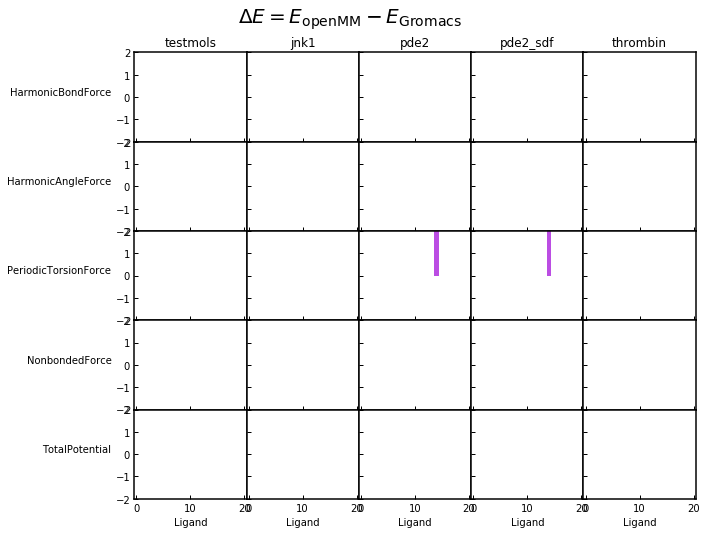

In [16]:
mpld3.enable_notebook()

plt.rcParams['figure.figsize'] = [12, 8]

fig, ax = plt.subplots(5, 5, sharex=True, sharey=True)

for ti, (t, ldict) in enumerate(energies.items()):
    for li, (l, edict) in enumerate(ldict.items()):
        for ei, (e, ene) in enumerate(edict.items()):
            ax[ei][ti].bar(li, ene[2])
for a in ax:
    for aa in a:
        aa.set_ylim(-2,2)
for a, l in zip(ax[:,0], energies['jnk1']['lig_17124-1'].keys()):
    a.set_ylabel(l, rotation=0, ha='right')
for a, l in zip(ax[-1,:], energies.keys()):
    a.set_xlabel('Ligand', rotation=0)
    #a.set_xticklabels(energies[l].keys())
for a, l in zip(ax[0,:], energies.keys()):
    a.set_title(l, rotation=0)
plt.gcf().suptitle('$\Delta E=E_{\mathrm{openMM}}-E_{\mathrm{Gromacs}}$', fontsize=20)
plt.savefig('energy_differences_openmm_gromacs.png')
plt.show()

#### Molecules with deviation > 0.01 kJ/mol in the total potential energy

=== pde2 ===
------------------------------------------------------------
--- lig_49582390 ---
------------------------------------------------------------
    HarmonicBondForce   :     5.80769e+01        5.80770e+01       -1.33177e-04
    HarmonicAngleForce  :     1.40846e+02        1.40845e+02        5.02085e-04
    PeriodicTorsionForce:     1.83800e+02        8.27378e+01        1.01062e+02
    NonbondedForce      :     2.54969e+02        2.54969e+02       -4.67503e-04
    TotalPotential      :     6.37691e+02        6.37691e+02        3.53888e-04
=== pde2_sdf ===
------------------------------------------------------------
--- lig_49582390 ---
------------------------------------------------------------
    HarmonicBondForce   :     5.70546e+01        5.70548e+01       -2.06148e-04
    HarmonicAngleForce  :     1.39793e+02        1.39793e+02        1.91357e-05
    PeriodicTorsionForce:     1.83867e+02        8.27818e+01        1.01085e+02
    NonbondedForce      :     2.54101e+02   

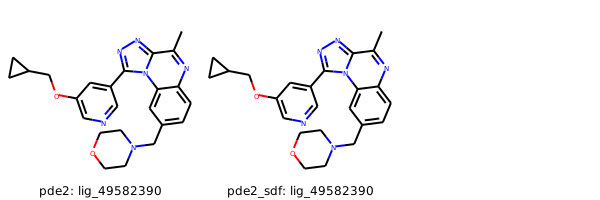

In [17]:
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
import rdkit.Chem.Draw as D
rdkitMols = []
for i, (target, ligand) in enumerate(np.unique(differing_molecules, axis=0)):
    print('=' * 60)
    print('=== ' + target + ' ===')
    print('=' * 60)
    ligPath = 'systems/' + target + '/' + ligand + '/' + ligand
        
    if os.path.isfile(ligPath+'.sdf'):
        print('-' * 60)
        print('--- ' + ligand + ' ---')
        print('-' * 60)
        mols = AllChem.SDMolSupplier(ligPath+'.sdf')
        for mol in mols:
            AllChem.Compute2DCoords(mol)
            mol.SetProp('_Name', target + ': ' + ligand)
            rdkitMols.append(mol)
    for k, item in energies[target][ligand].items():
        print('    {:20s}: {:15.5e}    {:15.5e}    {:15.5e}'.format(k, item[0], item[1], item[2]))
Draw.MolsToGridImage(rdkitMols, legends=[x.GetProp('_Name') for x in rdkitMols])

#### Minimized Energies

In [18]:
minEnergies={}
print('    {:20s}: {:15s}    {:15s}    {:15s}'.format('Energy contrib', 'openMM', 'Gromacs', 'Difference'))
for target in ['testmols', 'jnk1', 'pde2', 'pde2_sdf', 'thrombin']:
    print('=== ' + target + ' ===')
    minEnergies[target] = {}
    for key in openmmMinimizedEnergies[target].keys():
        print(key)
        minEnergies[target][key] = {}
        for kk, ene in openmmMinimizedEnergies[target][key].items():
            if kk == "NonbondedForce":
                gromacs_ene = sum([gromacsMinimizedEnergies[target][key][x] for x in ['LJ-14', 'Coulomb-14', 'LJ (SR)', 'Coulomb (SR)']])
            elif kk == 'PeriodicTorsionForce':
                gromacs_ene = gromacsMinimizedEnergies[target][key]['Proper Dih.']
                if 'Improper Dih.' in gromacsMinimizedEnergies[target][key].keys():
                    print('    {:20s}: {:8.2f}    {:8.2f}    {:8.2f}'.format('ImproperTorsionForce', 0.0, gromacsMinimizedEnergies[target][key]['Improper Dih.'], -gromacsMinimizedEnergies[target][key]['Improper Dih.']))
            elif kk == 'HarmonicAngleForce':
                gromacs_ene = gromacsMinimizedEnergies[target][key]['Angle']
            elif kk == 'HarmonicBondForce':
                gromacs_ene = gromacsMinimizedEnergies[target][key]['Bond']
            elif kk == 'TotalPotential':
                gromacs_ene = gromacsMinimizedEnergies[target][key]['Potential']
            else:
                print('Error: OpenMM Energy not known.')
            minEnergies[target][key][kk]=np.array([ene.value_in_unit(unit.kilojoules_per_mole), gromacs_ene, ene.value_in_unit(unit.kilojoules_per_mole)-gromacs_ene])
            print('    {:20s}: {:15.5e}    {:15.5e}    {:15.5e}'.format(kk, ene.value_in_unit(unit.kilojoules_per_mole), gromacs_ene, ene.value_in_unit(unit.kilojoules_per_mole)-gromacs_ene))

    Energy contrib      : openMM             Gromacs            Difference     
=== testmols ===
acetone
    HarmonicBondForce   :     3.14562e-02        1.11794e+00       -1.08648e+00
    HarmonicAngleForce  :     3.83688e-02        1.95430e+00       -1.91593e+00
    PeriodicTorsionForce:     2.00576e+01        2.20969e+01       -2.03930e+00
    NonbondedForce      :    -9.49103e+01       -9.28924e+01       -2.01791e+00
    TotalPotential      :    -7.47829e+01       -6.77228e+01       -7.06009e+00
benzaldehyde
    HarmonicBondForce   :     9.57790e-01        2.40253e+00       -1.44474e+00
    HarmonicAngleForce  :     3.14087e-01        1.35771e+00       -1.04362e+00
    PeriodicTorsionForce:     1.25898e-04        2.04156e-02       -2.02897e-02
    NonbondedForce      :     5.43804e+01        5.65423e+01       -2.16197e+00
    TotalPotential      :     5.56524e+01        6.03230e+01       -4.67063e+00
benzene
    HarmonicBondForce   :     4.94555e-01        8.82484e-01       -3.8792

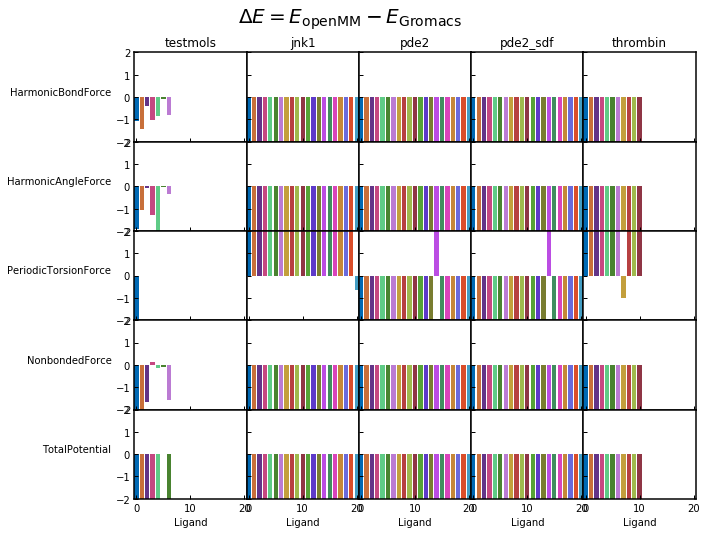

In [19]:
mpld3.enable_notebook()

plt.rcParams['figure.figsize'] = [12, 8]

fig, ax = plt.subplots(5, 5, sharex=True, sharey=True)

for ti, (t, ldict) in enumerate(minEnergies.items()):
    for li, (l, edict) in enumerate(ldict.items()):
        for ei, (e, ene) in enumerate(edict.items()):
            ax[ei][ti].bar(li, ene[2])
for a in ax:
    for aa in a:
        aa.set_ylim(-2,2)
for a, l in zip(ax[:,0], minEnergies['jnk1']['lig_17124-1'].keys()):
    a.set_ylabel(l, rotation=0, ha='right')
for a, l in zip(ax[-1,:], minEnergies.keys()):
    a.set_xlabel('Ligand', rotation=0)
    #a.set_xticklabels(energies[l].keys())
for a, l in zip(ax[0,:], energies.keys()):
    a.set_title(l, rotation=0)
plt.gcf().suptitle('$\Delta E=E_{\mathrm{openMM}}-E_{\mathrm{Gromacs}}$', fontsize=20)
plt.savefig('energy_minimized_differences_openmm_gromacs.png')
plt.show()

# Calculate RMSD between the minimized structures 
So far without roto-translational alignment

In [20]:
for target in ['testmols',  'jnk1', 'pde2', 'thrombin', 'pde2_sdf']:
    print('=' * 60)
    print('=== ' + target + ' ===')
    print('=' * 60)
    ligands = ! ls -d 'systems/'$target/*/
    for lig in ligands:
        lig = lig.split('/')
        ligPath = 'systems/' + target + '/' + lig[-2] + '/' + lig[-2]
        outPath = 'systems/' + target + '/' + lig[-2] + '/gromacs/' + lig[-2]
        if os.path.isfile(ligPath+'_minimized.pdb') and os.path.isfile(outPath+'_em.gro'):
            print('-' * 60)
            print('--- ' + lig[-2] + ' ---')
            print('-' * 60)
            gromacs_positions = pmd.load_file(outPath+'_em.gro')
            openmm_positions = pmd.load_file(ligPath+'_minimized.pdb')
#             print(type(gromacs_positions.positions.value_in_unit(unit.nanometer)), type(openmm_positions.positions.value_in_unit(unit.nanometer)))
#             print(gromacs_positions.positions.value_in_unit(unit.nanometer), openmm_positions.positions.value_in_unit(unit.nanometer))
#             print(np.array(gromacs_positions.positions.value_in_unit(unit.nanometer))-np.array(openmm_positions.positions.value_in_unit(unit.nanometer)))
#             print(np.square(np.array(gromacs_positions.positions.value_in_unit(unit.nanometer))-np.array(openmm_positions.positions.value_in_unit(unit.nanometer))))
            squared_distances = np.sum(np.square(np.array(gromacs_positions.positions.value_in_unit(unit.nanometer))-np.array(openmm_positions.positions.value_in_unit(unit.nanometer))), axis = 1)
#             print(squared_distances)
            print('    RMSD: {:.4f} nm'.format(np.sqrt(squared_distances.sum()/squared_distances.shape[0])))  

=== testmols ===
------------------------------------------------------------
--- acetone ---
------------------------------------------------------------
    RMSD: 0.1554 nm
------------------------------------------------------------
--- benzaldehyde ---
------------------------------------------------------------
    RMSD: 0.3031 nm
------------------------------------------------------------
--- benzene ---
------------------------------------------------------------
    RMSD: 0.2853 nm
------------------------------------------------------------
--- ethane ---
------------------------------------------------------------
    RMSD: 0.0012 nm
------------------------------------------------------------
--- ethanol ---
------------------------------------------------------------
    RMSD: 0.2081 nm
------------------------------------------------------------
--- methane ---
------------------------------------------------------------
    RMSD: 0.0005 nm
-------------------------------

------------------------------------------------------------
--- lig_1a ---
------------------------------------------------------------
    RMSD: 0.1489 nm
------------------------------------------------------------
--- lig_1b ---
------------------------------------------------------------
    RMSD: 0.1525 nm
------------------------------------------------------------
--- lig_1c ---
------------------------------------------------------------
    RMSD: 0.1498 nm
------------------------------------------------------------
--- lig_1d ---
------------------------------------------------------------
    RMSD: 0.1073 nm
------------------------------------------------------------
--- lig_3a ---
------------------------------------------------------------
    RMSD: 0.1694 nm
------------------------------------------------------------
--- lig_3b ---
------------------------------------------------------------
    RMSD: 0.1953 nm
----------------------------------------------------------